In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2023-06-24 10:00:22.283955+02:00


# 0. import libraries, general settings

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import os
import Bio
import scanpy as sc
import csv
import statsmodels
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.colors as colors_mat
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator

from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from tqdm import tqdm
from Bio import SeqIO
from scipy.stats import hypergeom, fisher_exact
from sklearn.metrics import r2_score

# 1. Import phosporylation results and getting an overview

In [3]:
phospho_result = pd.read_csv('../data/proteomics/phospho/Contractions_analysis_V1/data_analysis_results_V1/Limma_results_V1.csv')

#divide into agitation (mech) and nitric oxide (no) results
phospho_mech = phospho_result[phospho_result['comparison'] == 'contraction_mechanical - control']
phospho_mech = phospho_mech[phospho_mech['Modified.Peptide'].str.contains('\(')] #This only keeps peptide with an actual phospho-site (P)

phospho_no = phospho_result[phospho_result['comparison'] == 'contraction_no - control']

#divide upregulation and downregulation of phosphorylation
mechanical_up = pd.read_csv('../output/proteomics/significant_changes/phospho/phospho_mech_significant_up.tsv', sep='\t')
mechanical_down = pd.read_csv('../output/proteomics/significant_changes/phospho/phospho_mech_significant_down.tsv', sep='\t')

NO_up = pd.read_csv('../output/proteomics/significant_changes/phospho/phospho_no_significant_up.tsv', sep='\t')
NO_down = pd.read_csv('../output/proteomics/significant_changes/phospho/phospho_no_significant_down.tsv', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '../data/proteomics/phospho/Contractions_analysis_V1/data_analysis_results_V1/Limma_results_V1.csv'

Import merged gene name tables to connect protein id to gene name:


In [ ]:
merged_names = pd.read_csv('../data/old_annotation_geneID_LUT.tsv', sep = '\t')
merged_names.rename(columns={'proteinID_70AA' : 'Protein.ID', 'merged_gene_name' : 'annotation'}, inplace=True)

How many phosphopeptides did we detect in total?

In [5]:
len(phospho_result[phospho_result['Modified.Peptide'].str.contains('\(')]['Modified.Peptide'].drop_duplicates()) #this ensures that I count peptides with at least one phosphosite

12165

In [6]:
#only keep significant hits
phospho_mech_sig = phospho_mech[phospho_mech['hit_annotation'] != 'no hit']

In [7]:
phospho_no = phospho_no[phospho_no['Modified.Peptide'].str.contains('\(')] #This only keeps peptide with an actual phospho-site (P)
phospho_no = phospho_no.loc[phospho_no['Protein.ID'].str.startswith('m')]

phospho_no_sig = phospho_no[phospho_no['hit_annotation'] != 'no hit']

In [8]:
#how many hits are significant when sponge is agitated?
len(phospho_mech_sig['Protein.ID'].drop_duplicates())

229

There are in total 229 proteins that are significantly regulated ('candidate' or 'hit') when the sponge is agitated. For a broader overview I will look at all peptides with an upregulation of 0.25 logFC to see if I can find a broad pattern of kinase activity happening.

In [9]:
#how many phosphopeptides does this correspond to?
len(phospho_mech_sig['Modified.Peptide'].drop_duplicates())

303

In [10]:
#how many hits are significant when sponge is treated with NO?
len(phospho_no_sig['Protein.ID'].drop_duplicates())

270

In [11]:
#how many phosphopeptides does this correspond to?
len(phospho_no_sig['Modified.Peptide'].drop_duplicates())

390

Export data for exploration in excel:

In [41]:
phospho_no['Protein.ID'] = phospho_no['Protein.ID'].str.strip()
phospho_no_annotated = phospho_no.merge(merged_names, on='Protein.ID', how='left')
phospho_no_annotated = phospho_no_annotated[~phospho_no_annotated['annotation'].isna()]

phospho_mech['Protein.ID'] = phospho_mech['Protein.ID'].str.strip()
phospho_mech_annotated = phospho_mech.merge(merged_names, on='Protein.ID', how='left')
phospho_mech_annotated = phospho_mech_annotated[~phospho_mech_annotated['annotation'].isna()]

In [44]:
phospho_no_annotated.to_excel('../paper/proteomics_suppl_excel_files/phospho_NO_treatment.xlsx')
phospho_mech_annotated.to_excel('../paper/proteomics_suppl_excel_files/phospho_agitation.xlsx')

# 2. Prediction of general kinase activities in NO-treated and agitated sponges

For the prediction of kinase activity, I will not limit the analysis to the significantly upregulated phosphorylated peptides but to those whith have a logFC of at least 0.25. With this, I might be able to pick up underlying enriched kinase activity in my dataset. 

This is going to be a three step process:
1. Analyze phosphotylated positions in the phosphoproteomics dataset
2. Predict computationally all potential phosphorylation sites and kinases
3. Fuse experimental with predition data to infer significant envolvement of certain kinases

## 2.1 Export phosphotylated peptides after mechanical and NO treatment with a minimal of logFC of 0.25:

This step is necessary so I can run them using the GUI version of GPS 5.0 (https://gps.biocuckoo.cn/download.php).

In [13]:
phospho_mech_up_notsig = phospho_mech[phospho_mech['logFC'] > 0.25]
phospho_mech_up_notsig.reset_index(drop = True, inplace=True)
phospho_mech_up_notsig['Protein.ID'] = phospho_mech_up_notsig['Protein.ID'].str.strip()

/tmp/ipykernel_94/1500894404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phospho_mech_up_notsig['Protein.ID'] = phospho_mech_up_notsig['Protein.ID'].str.strip()


In [14]:
phospho_no_up_notsig = phospho_no[phospho_no['logFC'] > 0.25]
phospho_no_up_notsig.reset_index(drop = True, inplace=True)
phospho_no_up_notsig['Protein.ID'] = phospho_no_up_notsig['Protein.ID'].str.strip()

/tmp/ipykernel_94/402321710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phospho_no_up_notsig['Protein.ID'] = phospho_no_up_notsig['Protein.ID'].str.strip()


Import fasta sequences for all proteins:

In [15]:
fasta = '../data/S_lacustris_proteome.pep'

proteome = Bio.SeqIO.parse(fasta, 'fasta')
proteome = list(proteome)

In [16]:
handle_list =[]
fasta_list = []
for i in range(len(list(proteome))):
    handle_list.append(proteome[i].id)
    fasta_list.append(str(proteome[i].seq).replace('*', ''))
d = {'protein_id':handle_list,'fasta':fasta_list}
proteome_df = pd.DataFrame(d)

Create table that connects protein ID with protein sequence.

In [17]:
proteome_df['Protein.ID'] = proteome_df['protein_id'].str.split('_').str[-1].astype(str)
proteome_df = proteome_df[['Protein.ID', 'fasta']]

In [18]:
phospho_mech_up_notsig_fasta = phospho_mech_up_notsig[['Protein.ID']].merge(proteome_df, on='Protein.ID', how='left').drop_duplicates()
phospho_no_up_notsig_fasta = phospho_no_up_notsig[['Protein.ID']].merge(proteome_df, on='Protein.ID', how='left').drop_duplicates()

In [19]:
phospho_both_notsig_fasta_unique = phospho_no_up_notsig_fasta.append(phospho_mech_up_notsig_fasta).drop_duplicates()

Write fasta file for processing in GPS 5.0: (this only happens once). GPS 5.0 (https://www.sciencedirect.com/science/article/pii/S1672022920300279) is able to predict potential phosphorylation sites and their kinases from protein sequence data. For the prediction, I will use unique protein identiers from the combined logFC 0.25 of NO and mechanical treated sponges. The prediction threshold was set to 'high'.

In [20]:
#ofile = open("../data/GPS/phosphorylation_logfc_0.25_mech_no_unique.fasta", "w")

#for i, row in phospho_both_notsig_fasta_unique.iterrows():
#    ofile.write(">" + row['Protein.ID'] + "\n" + row['fasta'] + "\n")

#ofile.close()

In [21]:
phospho_mech_up_notsig = phospho_mech_up_notsig[['Protein.ID', 'Modified.Peptide']].merge(phospho_mech_up_notsig_fasta, on='Protein.ID', how='left')
phospho_no_up_notsig = phospho_no_up_notsig[['Protein.ID', 'Modified.Peptide']].merge(phospho_no_up_notsig_fasta, on='Protein.ID', how='left')

## 2.2 Searching the position of the modified peptide

So, the problem can actually be broken down in two sub-problems: finding the position of the peptide inside the complete sequence, and finding the position of the phosphorylated residue inside the peptide. Let's start with the first one.

In [22]:
for index, row in phospho_mech_up_notsig.iterrows():
    peptide_unmodified = row["Modified.Peptide"].replace("(P)", "")  

So the code above lets us build the putative "original" peptide. Now let's try finding the offset of that peptide inside the full sequence: luckily, there's a function from the standard library to do that, [`str.find`](https://docs.python.org/3/library/stdtypes.html#str.find). That function returns the position of the first occurence of a substring inside a string, or `-1` if the substring cannot be found.

In [23]:
for index, row in phospho_mech_up_notsig.iterrows():
    position = row["fasta"].find(peptide_unmodified)

To sanity check, we can make sure that the position is not `-1`, which would be the case if none of the two peptide were found in the original sequence:

In [24]:
for index, row in phospho_mech_up_notsig.iterrows():
    peptide_unmodified = row["Modified.Peptide"].replace("(P)", "")
    position = row["fasta"].find(peptide_unmodified)
    assert position != -1

*Aaaaaand* to sanity check even further, we could check that the modified peptide doesn't appear more than once in the original! Otherwise we may have a problem. To do that, we can count the number of time each peptide appears in the full sequence, and make sure the number of occurences of both peptides is exactly one:

Now we can build an extra columns for the dataframe with the offset of the modified peptide inside the main sequence:

In [25]:
peptide_offsets = []
for index, row in phospho_mech_up_notsig.iterrows():
    peptide_unmodified = row["Modified.Peptide"].replace("(P)", "")
    position = row["fasta"].find(peptide_unmodified)   
    assert row["fasta"].count(peptide_unmodified) >= 1
    peptide_offsets.append(position)
phospho_mech_up_notsig["peptide_offset"] = peptide_offsets
phospho_mech_up_notsig

Protein.ID                                   Modified.Peptide  \
0       m.81241                                      EEAT(P)PPLVAK   
1       m.81241                               ALAQHDFTST(P)TTTESPK   
2       m.81241                                         TES(P)PETK   
3       m.58479                                      LKEDT(P)PDAAK   
4       m.81241                                   EEEAPQTNS(P)PQVK   
...         ...                                                ...   
2540    m.57314                                  APQCPVNFLT(P)LHFR   
2541    m.75873                     HEGLPS(P)SPLTSSSPLVPS(P)SPLATK   
2542    m.35152                                        HNS(P)PEKPR   
2543    m.41818                                     VRPS(P)LATLEPK   
2544    m.38163  EASGGDPAELEGEAEGEEEEEEEVAEGGAEEKDNPAEQS(P)PHVI...   

                                                  fasta  peptide_offset  
0     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             951  
1     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             655  
2     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             980  
3     HAMEDFLYCRFNARGRKQFASLRITPDEFARKHPDVAKVTLPAHKA...             402  
4     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             875  
...                                                 ...             ...  
2540  GLMAAAKRAAGVEYRDSPLSRGPTIEAEDVPKPAKDQIRRRSSEKR...             333  
2541  MTSTNQPLPRWGHAAVAHQTKVYVWGGRLEDFSLSSRKSCGGVVDV...             685  
2542  MSRRDKKFRQTYPGPNAADNQQMLQDIKQTLEDHQKNEPAGAAVDK...             217  
2543  RVTTVGLATSEGTHPDVEPEPKVKPKSVDVTQSLPVDGRRRVSFSA...             164  
2544  LTFVSNTGYMAEEEAEVIEIDMAELKKMKVADLKKKVAELGIEAAG...              82  

[2545 rows x 4 columns]

The same for NO treated sponges:

In [26]:
peptide_offsets = []
for index, row in phospho_no_up_notsig.iterrows():
    peptide_unmodified = row["Modified.Peptide"].replace("(P)", "")
    position = row["fasta"].find(peptide_unmodified)   
    assert row["fasta"].count(peptide_unmodified) >= 1
    peptide_offsets.append(position)
phospho_no_up_notsig["peptide_offset"] = peptide_offsets
phospho_no_up_notsig

Protein.ID            Modified.Peptide  \
0       m.26830         KLS(P)QMQATPSDAQQDK   
1       m.55442  IS(P)TGTPPTSGSSSGGSTPVAITK   
2       m.58479              KIS(P)LDPTAQPK   
3       m.12319              ARPS(P)LQELPSK   
4       m.55442  IST(P)GTPPTSGSSSGGSTPVAITK   
...         ...                         ...   
2006    m.40912                MLS(P)IDDDYK   
2007    m.41966           AAS(P)VSLHAGTDGLR   
2008    m.88919            HGDDDGSHGSS(P)PK   
2009    m.48667           GHLSDYASPLT(P)SVK   
2010    m.35152                 HNS(P)PEKPR   

                                                  fasta  peptide_offset  
0     MAAQQRLVALLEHYRNRLHGLGDDVHDEELEYVHQILSSPLFRLYK...             116  
1     GGGGGGGGKLRSTTSVDTVLSEWQQLSLLKIAGPCVTCLLPHISED...             195  
2     HAMEDFLYCRFNARGRKQFASLRITPDEFARKHPDVAKVTLPAHKA...             941  
3     VVEGDGDKCKGTAPTKDALTGELTGQLSEESSYRTCQLQLMGGLSQ...             161  
4     GGGGGGGGKLRSTTSVDTVLSEWQQLSLLKIAGPCVTCLLPHISED...             195  
...                                                 ...             ...  
2006  MDLPDNLHELKRAALQKLCKAFGIRANMKSADMISELEELRNKARK...             354  
2007  SGPFIVDFESETCESSQVGGKSKNLWRLSRLVDSTCAKVPSWFCIT...             607  
2008  GHVRVSTPLPYYISELLYVAPAHLENARTVPLHVVTVGTACNGGCL...              62  
2009  PSPTNLVPPDLDLQRVPTGVPRIAKRSHTMMLGSTGSLNNISGPTS...             140  
2010  MSRRDKKFRQTYPGPNAADNQQMLQDIKQTLEDHQKNEPAGAAVDK...             217  

[2011 rows x 4 columns]

## 2.3 Searching the position of the phosphorylated residue

Finding the position of the phosphorylated residue in the modified peptide is even faster! All you have to do is to check for the index of the `(P)` inside the modified peptide, again with the `str.find` function.

In [27]:
for index, row in phospho_mech_up_notsig.iterrows():
    position = row["Modified.Peptide"].find("(P)")
    assert position != -1

Actually, since we *know* in advance the modified peptide always contain the `(P)` substring, we can use the `str.index` method instead, which does the same thing as `str.find`, but raises an error when the substring cannot be found; this way we don't even have to sanity check ourselves.

In [28]:
for index, row in phospho_mech_up_notsig.iterrows():
    position = row["Modified.Peptide"].index("(P)")

Now we can create an additional column for the offset of the phosphorylated residue inside the modified peptide:

In [30]:
residue_offsets = []
for index, row in phospho_mech_up_notsig.iterrows():
    position = row["Modified.Peptide"].index("(P)")
    residue_offsets.append(position)
phospho_mech_up_notsig["residue_offset"] = residue_offsets
phospho_mech_up_notsig.head(n=10)

Protein.ID      Modified.Peptide  \
0    m.81241         EEAT(P)PPLVAK   
1    m.81241  ALAQHDFTST(P)TTTESPK   
2    m.81241            TES(P)PETK   
3    m.58479         LKEDT(P)PDAAK   
4    m.81241      EEEAPQTNS(P)PQVK   
5    m.58779          RAS(P)LPAVLR   
6    m.50556       KAEQLYES(P)QELK   
7    m.80847     VDMFHDDFEPS(P)TSK   
8    m.80847    QPPAKPTLYES(P)QELK   
9    m.50556        INPLYES(P)QELK   

                                               fasta  peptide_offset  \
0  HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             951   
1  HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             655   
2  HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             980   
3  HAMEDFLYCRFNARGRKQFASLRITPDEFARKHPDVAKVTLPAHKA...             402   
4  HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             875   
5  PNLSGCKNLIEVLLEQNLLTTLDVSTFKGLSRLRTIDLSYNAISSL...             665   
6  VHDNTEFDLEPVPTKRTPKKAEQLYESQELKVDMVHDNTEFDLEPV...              19   
7  DYYIPAYILTVMSQCGGTTSIITVSIYVLDVNNHAPVISNISYCIP...             614   
8  DYYIPAYILTVMSQCGGTTSIITVSIYVLDVNNHAPVISNISYCIP...             599   
9  VHDNTEFDLEPVPTKRTPKKAEQLYESQELKVDMVHDNTEFDLEPV...             154   

   residue_offset  
0               4  
1              10  
2               3  
3               5  
4               9  
5               3  
6               8  
7              11  
8              11  
9               7

Actually, there is an ever faster way to do this, using the `pandas` interface to do that without even having to loop on the dataframe manually! Here's how:

In [31]:
phospho_mech_up_notsig["residue_offset"] = phospho_mech_up_notsig["Modified.Peptide"].str.index("(P)")
phospho_mech_up_notsig

Protein.ID                                   Modified.Peptide  \
0       m.81241                                      EEAT(P)PPLVAK   
1       m.81241                               ALAQHDFTST(P)TTTESPK   
2       m.81241                                         TES(P)PETK   
3       m.58479                                      LKEDT(P)PDAAK   
4       m.81241                                   EEEAPQTNS(P)PQVK   
...         ...                                                ...   
2540    m.57314                                  APQCPVNFLT(P)LHFR   
2541    m.75873                     HEGLPS(P)SPLTSSSPLVPS(P)SPLATK   
2542    m.35152                                        HNS(P)PEKPR   
2543    m.41818                                     VRPS(P)LATLEPK   
2544    m.38163  EASGGDPAELEGEAEGEEEEEEEVAEGGAEEKDNPAEQS(P)PHVI...   

                                                  fasta  peptide_offset  \
0     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             951   
1     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             655   
2     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             980   
3     HAMEDFLYCRFNARGRKQFASLRITPDEFARKHPDVAKVTLPAHKA...             402   
4     HETSLFCSLCGKMFEKSLNDLVRGIRAHKGQEAQYISQCMAEIKKE...             875   
...                                                 ...             ...   
2540  GLMAAAKRAAGVEYRDSPLSRGPTIEAEDVPKPAKDQIRRRSSEKR...             333   
2541  MTSTNQPLPRWGHAAVAHQTKVYVWGGRLEDFSLSSRKSCGGVVDV...             685   
2542  MSRRDKKFRQTYPGPNAADNQQMLQDIKQTLEDHQKNEPAGAAVDK...             217   
2543  RVTTVGLATSEGTHPDVEPEPKVKPKSVDVTQSLPVDGRRRVSFSA...             164   
2544  LTFVSNTGYMAEEEAEVIEIDMAELKKMKVADLKKKVAELGIEAAG...              82   

      residue_offset  
0                  4  
1                 10  
2                  3  
3                  5  
4                  9  
...              ...  
2540              10  
2541               6  
2542               3  
2543               4  
2544              39  

[2545 rows x 5 columns]

And the same for the NO treated sponges:

In [32]:
phospho_no_up_notsig["residue_offset"] = phospho_no_up_notsig["Modified.Peptide"].str.index("(P)")

## 2.4 Computing the final residue position

Now that we have the offset of the peptide in the complete protein, and the offset of the residue inside the peptide, all that's left to do is to add them and we'll have the offset of the phosphorylated residue inside the complete sequence! This can be done by adding the columns together, since `pandas` will take care of doing the pairwise addition for us:

In [33]:
phospho_mech_up_notsig["phosphorylated_residue"] = phospho_mech_up_notsig["peptide_offset"] + phospho_mech_up_notsig["residue_offset"]
phospho_mech_up_notsig = phospho_mech_up_notsig.sort_values(by='Protein.ID')

Note that the offsets are gonna be zero-based! We can add a final sanity check to make sure that the position we computed is either a Serine, Threonine or Tyrosine, as any other residue would probably make us think we fucked up somewhere:

In [34]:
for index, row in phospho_mech_up_notsig.iterrows():
    aa = row["fasta"][ row["phosphorylated_residue"] - 1 ]
    assert aa == "T" or aa == "S" or aa == "Y"

No error! We did it! **Yay!**

And again the same for NO treated sponges:

In [35]:
phospho_no_up_notsig["phosphorylated_residue"] = phospho_no_up_notsig["peptide_offset"] + phospho_no_up_notsig["residue_offset"]
phospho_no_up_notsig = phospho_no_up_notsig.sort_values(by='Protein.ID')

## 2.5 Import prediction of Phosphosites and kinases (GPS 5.0)

We used GPS 5.0 to predict phosphosites and corresponding kinases for all proteins of the Spongilla proteome which have a phosphorylated peptided with logFC >0.25 in the mechanical or NO treatment experiments. The theshold for the search was set to 'High'. The output is pretty strange so I have to read it in like this:

In [36]:
import pandas

with open("../data/GPS/GPS_NO_mech_025_unique_results.txt") as file:
    header = file.readline().strip().split("\t")
    header.append("Protein.ID")
    rows = []
    for line in file:       
        if line.startswith(">"):
            current_sequence = line[1:].strip()
        else:
            row = line.strip().split("\t")
            row.append(current_sequence)
            rows.append(row)
            
predictions = pandas.DataFrame(rows, columns=header)

In [37]:
predictions.rename(columns={'Position':'phosphorylated_residue'}, inplace=True)

In [38]:
predictions['phosphorylated_residue'] = predictions['phosphorylated_residue'].astype(str).astype(int)

## 2.6 Merge experimental and prediction data to infer kinase involvement

I first need to define a Background (BG) which I will use to compare the experimental phosphosites against. The background are ALL potential phosphosites in the respective experiments (mech, no):

In [39]:
predictions_mech = predictions[predictions['Protein.ID'].isin(phospho_mech_up_notsig['Protein.ID'])]
predictions_no = predictions[predictions['Protein.ID'].isin(phospho_no_up_notsig['Protein.ID'])]

In [40]:
BG_kinases = pd.DataFrame(predictions['Kinase'].value_counts())
BG_kinases_mech = pd.DataFrame(predictions_mech['Kinase'].value_counts())
BG_kinases_no = pd.DataFrame(predictions_no['Kinase'].value_counts())

I can now merge the experimental data with the predicted data on Protein.ID and phosphorylated_residue:

In [41]:
mech_exp_pred_merge = phospho_mech_up_notsig.merge(predictions_mech, on=['Protein.ID', 'phosphorylated_residue'], how='left')
no_exp_pred_merge = phospho_no_up_notsig.merge(predictions_no, on=['Protein.ID', 'phosphorylated_residue'], how='left')

In [42]:
mech_exp_kinases = pd.DataFrame(mech_exp_pred_merge['Kinase'].value_counts())
no_exp_kinases = pd.DataFrame(no_exp_pred_merge['Kinase'].value_counts())

In [43]:
mech_combined_kinases = BG_kinases_mech.join(mech_exp_kinases, lsuffix='_BG', rsuffix='_exp')
no_combined_kinases = BG_kinases_no.join(no_exp_kinases, lsuffix='_BG', rsuffix='_exp')

There are in total 614 different kinases we can test for enrichment.

### Enrichment of Kinases in mechanical or NO treated sponges

Testing enrichment of kinases in the experimental data is carried out using the hypergeometric test with a contingency table:

In [44]:
pred_events_mech = sum(BG_kinases_mech['Kinase'])
pred_events_no = sum(BG_kinases_no['Kinase'])

mech_exp_events = sum(mech_exp_kinases['Kinase'])
no_exp_events = sum(no_exp_kinases['Kinase'])

In [45]:
pvalue_mech = []
for index, row in mech_combined_kinases.iterrows():
    x = row['Kinase_exp']
    M = pred_events_mech
    n = row['Kinase_BG']
    N = mech_exp_events
    pval = hypergeom.sf(x-1, M, n, N)
    pvalue_mech.append(pval)
mech_combined_kinases["pvalue"] = pvalue_mech

In [46]:
pvalue_no = []
for index, row in no_combined_kinases.iterrows():
    x = row['Kinase_exp']
    M = pred_events_no
    n = row['Kinase_BG']
    N = no_exp_events
    pval = hypergeom.sf(x-1, M, n, N)
    pvalue_no.append(pval)
no_combined_kinases["pvalue"] = pvalue_no

In [47]:
mech_combined_kinases = mech_combined_kinases[~mech_combined_kinases['pvalue'].isnull()]
mech_combined_kinases['adj_pvalue'] = statsmodels.stats.multitest.fdrcorrection(mech_combined_kinases['pvalue'])[1]
mech_combined_kinases['fold_enrichment'] = (mech_combined_kinases['Kinase_exp']/mech_exp_events)/(mech_combined_kinases['Kinase_BG']/pred_events_mech)
mech_combined_kinases_plotting = mech_combined_kinases.sort_values(by='fold_enrichment', ascending=False)

no_combined_kinases = no_combined_kinases[~no_combined_kinases['pvalue'].isnull()]
no_combined_kinases['adj_pvalue'] = statsmodels.stats.multitest.fdrcorrection(no_combined_kinases['pvalue'])[1]
no_combined_kinases['fold_enrichment'] = (no_combined_kinases['Kinase_exp']/no_exp_events)/(no_combined_kinases['Kinase_BG']/pred_events_no)
no_combined_kinases_plotting = no_combined_kinases.sort_values(by='fold_enrichment', ascending=False)

In [48]:
mech_combined_kinases.sort_values(by='pvalue', ascending=True).to_csv('../output/proteomics/enriched_kinases_mech.tsv', sep='\t')
no_combined_kinases.sort_values(by='pvalue', ascending=True).to_csv('../output/proteomics/enriched_kinases_no.tsv', sep='\t')

It probably makes sense to sum the kinases on the family level. In order to do that, I need to start with the full list experimental and predicted phosphosites again. I will only keep protein family level assignment and delete duplicates, otherwise I will count some phosphosite assignments double (or even more often)

The same operation has to happen for the predictions as well as the mech and NO lists:

In [49]:
predictions_mech['Kinase_family'] = predictions_mech['Kinase'].str.split('/').str[1]
predictions_mech['Kinase_family'].fillna(predictions_mech['Kinase'], inplace=True)

predictions_mech_unique_family = predictions_mech[['Protein.ID', 'Peptide', 'Kinase_family', 'phosphorylated_residue']].drop_duplicates()
predictions_mech_unique_family_counts = pd.DataFrame(predictions_mech_unique_family['Kinase_family'].value_counts())

/tmp/ipykernel_94/770135464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_mech['Kinase_family'] = predictions_mech['Kinase'].str.split('/').str[1]
/tmp/ipykernel_94/770135464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_mech['Kinase_family'].fillna(predictions_mech['Kinase'], inplace=True)


In [50]:
predictions_no['Kinase_family'] = predictions_no['Kinase'].str.split('/').str[1]
predictions_no['Kinase_family'].fillna(predictions_no['Kinase'], inplace=True)

predictions_no_unique_family = predictions_no[['Protein.ID', 'Peptide', 'Kinase_family', 'phosphorylated_residue']].drop_duplicates()
predictions_no_unique_family_counts = pd.DataFrame(predictions_no_unique_family['Kinase_family'].value_counts())

/tmp/ipykernel_94/2054146337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_no['Kinase_family'] = predictions_no['Kinase'].str.split('/').str[1]
/tmp/ipykernel_94/2054146337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_no['Kinase_family'].fillna(predictions_no['Kinase'], inplace=True)


In [51]:
mech_exp_pred_merge['Kinase_family'] = mech_exp_pred_merge['Kinase'].str.split('/').str[1] #Split Kinases and keep family level
mech_exp_pred_merge['Kinase_family'].fillna(mech_exp_pred_merge['Kinase'], inplace=True) #In case there is only one Kinase, keep that.

mech_exp_pred_merge_unique_family = mech_exp_pred_merge[['Protein.ID', 'Modified.Peptide', 'Kinase_family']].drop_duplicates() #Drop all duplicates of Kinase family members phosphoorylating the same peptide and phosphosite
mech_exp_pred_merge_unique_family_counts = pd.DataFrame(mech_exp_pred_merge_unique_family['Kinase_family'].value_counts()) #count all values for contingency table

In [52]:
no_exp_pred_merge['Kinase_family'] = no_exp_pred_merge['Kinase'].str.split('/').str[1] #Split Kinases and keep family level
no_exp_pred_merge['Kinase_family'].fillna(no_exp_pred_merge['Kinase'], inplace=True) #In case there is only one Kinase, keep that.

no_exp_pred_merge_unique_family = no_exp_pred_merge[['Protein.ID', 'Modified.Peptide', 'Kinase_family']].drop_duplicates() #Drop all duplicates of Kinase family members phosphoorylating the same peptide and phosphosite
no_exp_pred_merge_unique_family_counts = pd.DataFrame(no_exp_pred_merge_unique_family['Kinase_family'].value_counts()) #count all values for contingency table

In [53]:
mech_combined_kinases_family = predictions_mech_unique_family_counts.join(mech_exp_pred_merge_unique_family_counts, lsuffix='_BG', rsuffix='_exp')
no_combined_kinases_family = predictions_no_unique_family_counts.join(no_exp_pred_merge_unique_family_counts, lsuffix='_BG', rsuffix='_exp')

In [54]:
mech_combined_kinases_family.dropna(inplace=True)
no_combined_kinases_family.dropna(inplace=True)

I need to define new instances of all prediction events and all experimental events

In [55]:
pred_mech_events_family = sum(mech_combined_kinases_family['Kinase_family_BG'])
pred_no_events_family = sum(no_combined_kinases_family['Kinase_family_BG'])

mech_exp_events_family = sum(mech_combined_kinases_family['Kinase_family_exp'])
no_exp_events_family = sum(no_combined_kinases_family['Kinase_family_exp'])

In [56]:
pvalue = []
for index, row in mech_combined_kinases_family.iterrows():
    x = row['Kinase_family_exp']
    M = pred_mech_events_family
    n = row['Kinase_family_BG']
    N = mech_exp_events_family
    pval = hypergeom.sf(x-1, M, n, N)
    pvalue.append(pval)
mech_combined_kinases_family["pvalue"] = pvalue

In [57]:
pvalue = []
for index, row in no_combined_kinases_family.iterrows():
    x = row['Kinase_family_exp']
    M = pred_no_events_family
    n = row['Kinase_family_BG']
    N = no_exp_events_family
    pval = hypergeom.sf(x-1, M, n, N)
    pvalue.append(pval)
no_combined_kinases_family["pvalue"] = pvalue

In [58]:
mech_combined_kinases_family['adj_pvalue'] = statsmodels.stats.multitest.fdrcorrection(mech_combined_kinases_family['pvalue'])[1]
mech_combined_kinases_family['fold_enrichment'] = (mech_combined_kinases_family['Kinase_family_exp']/mech_exp_events_family)/(mech_combined_kinases_family['Kinase_family_BG']/pred_mech_events_family)

no_combined_kinases_family['adj_pvalue'] = statsmodels.stats.multitest.fdrcorrection(no_combined_kinases_family['pvalue'])[1]
no_combined_kinases_family['fold_enrichment'] = (no_combined_kinases_family['Kinase_family_exp']/no_exp_events_family)/(no_combined_kinases_family['Kinase_family_BG']/pred_no_events_family)

Now I want to plot all kinases that show at least a 1.5 x Fold enrichment

In [59]:
mech_combined_kinases_family_plotting = mech_combined_kinases_family[mech_combined_kinases_family['fold_enrichment'] > 1.5]

In [60]:
mech_combined_kinases_family_plotting.sort_values(by='fold_enrichment', ascending=False, inplace=True)
mech_combined_kinases_family_plotting['adj_pvalue_log10'] = -1 * mech_combined_kinases_family_plotting['adj_pvalue'].apply(lambda x: np.log10(x) if x > 0 else 0)

/tmp/ipykernel_94/596510441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mech_combined_kinases_family_plotting.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_94/596510441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mech_combined_kinases_family_plotting['adj_pvalue_log10'] = -1 * mech_combined_kinases_family_plotting['adj_pvalue'].apply(lambda x: np.log10(x) if x > 0 else 0)


In [61]:
order = mech_combined_kinases_family_plotting.sort_values(by='fold_enrichment', ascending=False).index

/tmp/ipykernel_94/2006360944.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cmap)


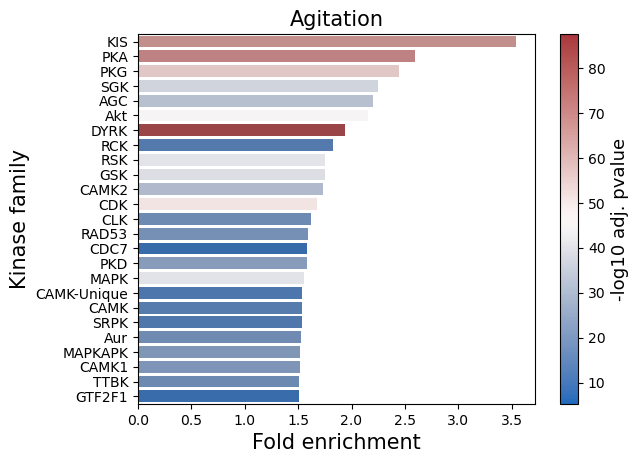

In [62]:
norm = colors_mat.Normalize(vmin=mech_combined_kinases_family_plotting['adj_pvalue_log10'].min(), vmax=mech_combined_kinases_family_plotting['adj_pvalue_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")
colors = cmap.to_rgba(mech_combined_kinases_family_plotting['adj_pvalue_log10'])

ax = sns.barplot(data = mech_combined_kinases_family_plotting, y = mech_combined_kinases_family_plotting.index, 
            x=mech_combined_kinases_family_plotting['fold_enrichment'], order=order, palette=colors)
plt.colorbar(cmap)
ax.figure.axes[-1].set_ylabel('-log10 adj. pvalue', size=13)
ax.set_xlabel('Fold enrichment', fontsize=15)
ax.set_ylabel('Kinase family', fontsize=15)
ax.set_title('Agitation', size=15)

plt.savefig('../paper/figures/suppl_figs/enrichemnt_kinases_agitation.svg', bbox_inches='tight')

In [63]:
no_combined_kinases_family_plotting = no_combined_kinases_family[no_combined_kinases_family['fold_enrichment'] > 1.5]

In [64]:
no_combined_kinases_family_plotting.sort_values(by='fold_enrichment', ascending=False, inplace=True)
no_combined_kinases_family_plotting['adj_pvalue_log10'] = -1 * no_combined_kinases_family_plotting['adj_pvalue'].apply(lambda x: np.log10(x) if x > 0 else 0)

/tmp/ipykernel_94/3516675565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_combined_kinases_family_plotting.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_94/3516675565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_combined_kinases_family_plotting['adj_pvalue_log10'] = -1 * no_combined_kinases_family_plotting['adj_pvalue'].apply(lambda x: np.log10(x) if x > 0 else 0)


In [65]:
order = no_combined_kinases_family_plotting.sort_values(by='fold_enrichment', ascending=False).index

/tmp/ipykernel_94/3447503062.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cmap)


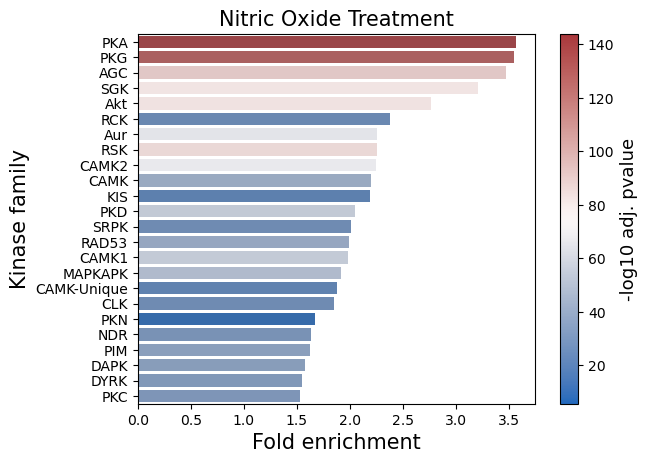

In [66]:
norm = colors_mat.Normalize(vmin=no_combined_kinases_family_plotting['adj_pvalue_log10'].min(), vmax=no_combined_kinases_family_plotting['adj_pvalue_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")
colors = cmap.to_rgba(no_combined_kinases_family_plotting['adj_pvalue_log10'])

ax = sns.barplot(data = no_combined_kinases_family_plotting, y = no_combined_kinases_family_plotting.index, 
            x=no_combined_kinases_family_plotting['fold_enrichment'], order=order, palette=colors)
plt.colorbar(cmap)
ax.figure.axes[-1].set_ylabel('-log10 adj. pvalue', size=13)
ax.set_xlabel('Fold enrichment', fontsize=15)
ax.set_ylabel('Kinase family', fontsize=15)
ax.set_title('Nitric Oxide Treatment', size=15)

plt.savefig('../paper/figures/suppl_figs/enrichemnt_kinases_NO.svg', bbox_inches='tight')


It would also be cool for direct comparison to plot both experiments next to each other:

In [67]:
kinase_family_combined = mech_combined_kinases_family.merge(no_combined_kinases_family, left_index=True, right_index=True, suffixes=('_mech', '_NO'))[['adj_pvalue_mech', 'adj_pvalue_NO', 'fold_enrichment_mech', 'fold_enrichment_NO']]

How do the enrichments correlate?

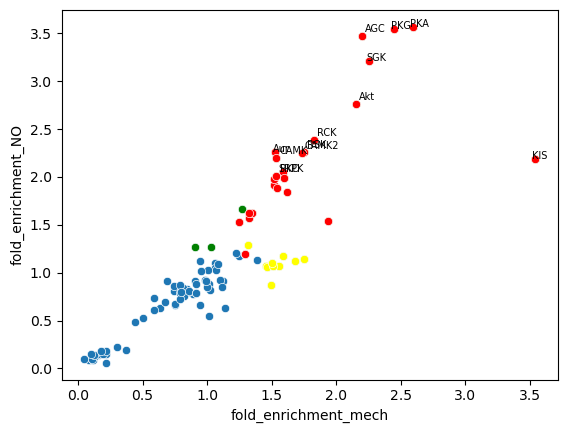

In [68]:
# Create the scatterplot
ax = sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=kinase_family_combined)

# Color the points with adj_pvalue < 0.05 differently
mask_mech = (kinase_family_combined['adj_pvalue_mech'] < 0.001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=kinase_family_combined[mask_mech], color='yellow', ax=ax)

mask_NO = (kinase_family_combined['adj_pvalue_NO'] < 0.001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=kinase_family_combined[mask_NO], color='green', ax=ax)

mask_both = (kinase_family_combined['adj_pvalue_mech'] < 0.001) & (kinase_family_combined['adj_pvalue_NO'] < 0.001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=kinase_family_combined[mask_both], color='red', ax=ax)

# Print the index of each point with fold_enrichment > 2
mask = (kinase_family_combined['fold_enrichment_mech'] > 2) | (kinase_family_combined['fold_enrichment_NO'] > 2)
index = kinase_family_combined[mask].index
offset = 0.02
for i in index:
    x, y = kinase_family_combined.loc[i, ['fold_enrichment_mech', 'fold_enrichment_NO']]
    plt.text(x + offset, y + offset, i, fontsize=7, verticalalignment='bottom', horizontalalignment='left')
    offset = -offset

plt.show()

How does this look like if we don't focus on the kinase family level but take the possibility of individual kinases into account:

In [69]:
phopsho_events_combined = mech_combined_kinases.merge(no_combined_kinases, left_index=True, right_index=True, suffixes=('_mech', '_NO'))[['adj_pvalue_mech', 'adj_pvalue_NO', 'fold_enrichment_mech', 'fold_enrichment_NO']]

In [70]:
phopsho_events_combined.sort_values(by='fold_enrichment_NO', ascending=False).head(n=40)

adj_pvalue_mech  adj_pvalue_NO  \
AGC/PKG/PRKG1                 3.396841e-64  3.716782e-137   
AGC/PKG                       3.133351e-47  5.985909e-130   
AGC/PKA/PKACA                 6.992474e-48  2.282621e-133   
AGC/PKA                       1.083187e-46  1.082802e-136   
CAMK/PKD/PRKD1                3.356252e-42  1.935102e-101   
AGC/RSK/RSKp90/RPS6KA3        4.517539e-40   3.563381e-93   
AGC/PKC/PKCd/PRKCQ            3.608760e-29   1.118997e-99   
AGC                           1.291081e-28   1.773673e-96   
AGC/RSK/RSKp90                4.942848e-40   2.783674e-81   
CAMK                          2.099355e-31   2.225853e-79   
CAMK/CAMK2                    1.540155e-36   1.532521e-81   
CAMK/MAPKAPK/MK2/MAPKAPK3     6.057539e-29   4.056893e-64   
AGC/RSK/MSK                   2.054017e-21   1.977548e-70   
AGC/Akt/AKT1                  3.600694e-30   5.770626e-76   
CAMK/CAMK2/CAMK2A             5.382993e-33   5.770626e-76   
CAMK/MAPKAPK                  3.327949e-32   1.141921e-63   
AGC/DMPK/ROCK                 1.384204e-13   3.682996e-66   
AGC/Akt                       7.945556e-24   4.741099e-61   
CAMK/CAMKL/AMPK               7.916921e-36   8.493726e-71   
AGC/NDR/LATS/LATS1            2.618207e-14   1.531411e-24   
AGC/DMPK                      4.574339e-13   1.564126e-64   
Other/Aur                     3.539268e-17   1.935594e-67   
CAMK/DAPK/DAPK                2.433043e-23   1.833553e-67   
AGC/RSK/MSK/RPS6KA5           2.165219e-17   2.753500e-61   
AGC/RSK/RSKp90/RPS6KA2        1.060325e-28   1.074436e-62   
CAMK/RAD53/CHEK2              3.384015e-24   1.613377e-67   
AGC/RSK/RSKp70/RPS6KB2        6.124359e-24   9.422381e-61   
CAMK/CAMKL                    1.463497e-28   3.497388e-55   
CAMK/MAPKAPK/MK2              1.710365e-36   2.182477e-66   
CAMK/MAPKAPK/MK2/MAPKAPK2     1.710365e-36   2.182477e-66   
CAMK/CAMK1                    6.470816e-26   2.314575e-73   
AGC/PKG/PRKG2                 5.078731e-18   9.766382e-72   
AGC/SGK                       1.288117e-16   6.373125e-44   
CAMK/CAMK1/CAMK4              1.266283e-27   4.566818e-67   
AGC/SGK/SGK3                  2.812200e-20   1.970202e-48   
STE/STE20/PAKB                5.106266e-17   1.515678e-50   
STE/STE20/PAKA                6.451956e-09   7.413226e-41   
CAMK/DAPK                     2.631736e-20   2.847246e-65   
CAMK/CAMK1/CAMK1              1.313307e-10   3.849018e-46   
AGC/RSK                       3.079446e-22   1.303855e-46   

                           fold_enrichment_mech  fold_enrichment_NO  
AGC/PKG/PRKG1                          2.993117            4.487563  
AGC/PKG                                2.713227            4.447497  
AGC/PKA/PKACA                          2.532313            4.118468  
AGC/PKA                                2.484797            4.074302  
CAMK/PKD/PRKD1                         2.506311            3.769077  
AGC/RSK/RSKp90/RPS6KA3                 2.483829            3.639667  
AGC/PKC/PKCd/PRKCQ                     2.155731            3.617262  
AGC                                    2.116109            3.521068  
AGC/RSK/RSKp90                         2.486957            3.454710  
CAMK                                   2.290738            3.409633  
CAMK/CAMK2                             2.363943            3.354253  
CAMK/MAPKAPK/MK2/MAPKAPK3              2.369782            3.334129  
AGC/RSK/MSK                            2.043464            3.284934  
AGC/Akt/AKT1                           2.199805            3.247504  
CAMK/CAMK2/CAMK2A                      2.259505            3.227308  
CAMK/MAPKAPK                           2.341939            3.172719  
AGC/DMPK/ROCK                          1.789518            3.170302  
AGC/Akt                                2.152792            3.163950  
CAMK/CAMKL/AMPK                        2.307625            3.137450  
AGC/NDR/LATS/LATS1                     2.390573            3.135471  
AGC/DMPK                               1.760233        

How do the enrichments correlate?

Text(0.5, 1.0, 'Comparison of kinase target enrichment: NO vs. mechanical treatment')

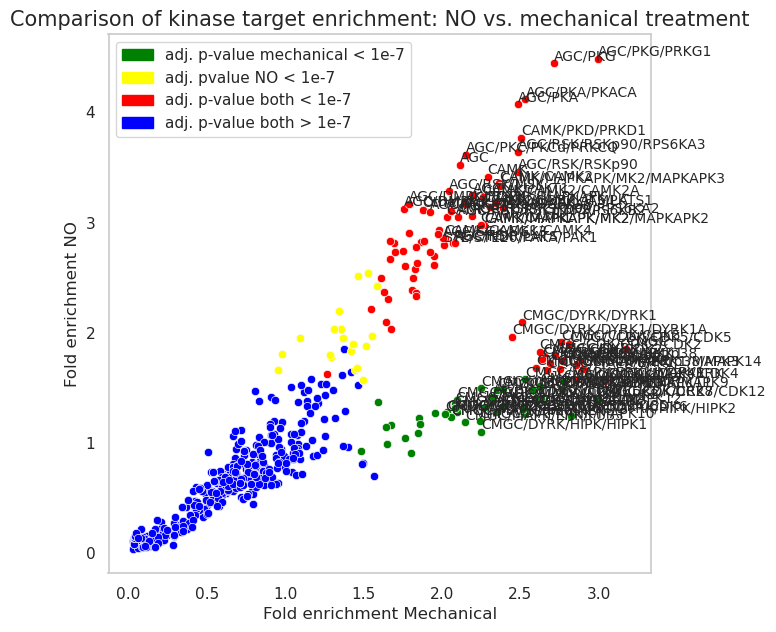

In [71]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.set_style("whitegrid", {'axes.grid': False})

# Create the scatterplot
ax = sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined)


mask_both_not = (phopsho_events_combined['adj_pvalue_mech'] > 0.0000001) & (phopsho_events_combined['adj_pvalue_NO'] > 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_both_not], color='blue', ax=ax)

mask_mech = (phopsho_events_combined['adj_pvalue_mech'] < 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_mech], color='green', ax=ax)

mask_NO = (phopsho_events_combined['adj_pvalue_NO'] < 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_NO], color='yellow', ax=ax)

mask_both = (phopsho_events_combined['adj_pvalue_mech'] < 0.0000001) & (phopsho_events_combined['adj_pvalue_NO'] < 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_both], color='red', ax=ax)

# Print the index of each point with fold_enrichment > 2
mask = (phopsho_events_combined['fold_enrichment_mech'] > 2) | (phopsho_events_combined['fold_enrichment_NO'] > 3)
index = phopsho_events_combined[mask].index
offset = 0
for i in index:
    x, y = phopsho_events_combined.loc[i, ['fold_enrichment_mech', 'fold_enrichment_NO']]
    plt.text(x + offset, y + offset, i, fontsize=10, verticalalignment='bottom', horizontalalignment='left')
    offset = -offset

ax.set_ylabel('Fold enrichment NO')
ax.set_xlabel('Fold enrichment Mechanical')

colors = ['green', 'yellow', 'red', 'blue']
labels = ['adj. p-value mechanical < 1e-7', 'adj. pvalue NO < 1e-7', 'adj. p-value both < 1e-7', 'adj. p-value both > 1e-7']

# Create a patch for each color and label
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Add the patches to the legend
plt.legend(handles=patches, loc='upper left')
ax.set_title('Comparison of kinase target enrichment: NO vs. mechanical treatment', size = 15)

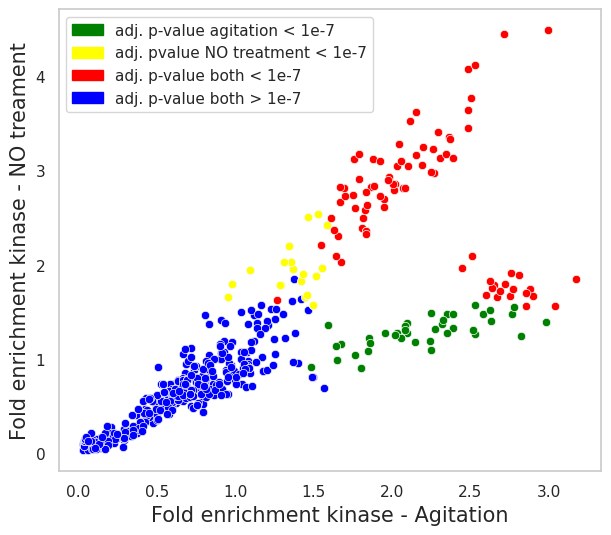

In [72]:
sns.set(rc={"figure.figsize":(7, 6)})
sns.set_style("whitegrid", {'axes.grid': False})

# Create the scatterplot
ax = sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined)


mask_both_not = (phopsho_events_combined['adj_pvalue_mech'] > 0.0000001) & (phopsho_events_combined['adj_pvalue_NO'] > 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_both_not], color='blue', ax=ax)

mask_mech = (phopsho_events_combined['adj_pvalue_mech'] < 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_mech], color='green', ax=ax)

mask_NO = (phopsho_events_combined['adj_pvalue_NO'] < 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_NO], color='yellow', ax=ax)

mask_both = (phopsho_events_combined['adj_pvalue_mech'] < 0.0000001) & (phopsho_events_combined['adj_pvalue_NO'] < 0.0000001)
sns.scatterplot(x="fold_enrichment_mech", y="fold_enrichment_NO", data=phopsho_events_combined[mask_both], color='red', ax=ax)

ax.set_ylabel('Fold enrichment kinase - NO treament', fontsize=15)
ax.set_xlabel('Fold enrichment kinase - Agitation', fontsize=15)

colors = ['green', 'yellow', 'red', 'blue']
labels = ['adj. p-value agitation < 1e-7', 'adj. pvalue NO treatment < 1e-7', 'adj. p-value both < 1e-7', 'adj. p-value both > 1e-7']

# Create a patch for each color and label
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Add the patches to the legend
plt.legend(handles=patches, loc='upper left')
#ax.set_title('Comparison of kinase target enrichment: NO vs. mechanical treatment', size = 15)
plt.savefig('../paper/figures/fig3/kinase_enrichment.svg', bbox_inches='tight')

What are these two branches? Or a better question, what is the branch that is mostly populated by mechanically enriched kinases?

In [73]:
green_branch = (phopsho_events_combined['fold_enrichment_mech'] > 1.5) & (phopsho_events_combined['fold_enrichment_NO'] < 2)

In [74]:
phopsho_events_combined[green_branch].sort_values(by='fold_enrichment_mech', ascending=False).head(n=20)

adj_pvalue_mech  adj_pvalue_NO  fold_enrichment_mech  \
CMGC                     5.900818e-88   6.698195e-14              3.175924   
CMGC/MAPK/ERK            8.761967e-96   9.328552e-09              3.040816   
CMGC/CDK/CRK7/CDK12      1.959434e-77   3.531885e-04              2.980052   
CMGC/CDK/CRK7            1.959434e-77   3.531885e-04              2.980052   
CMGC/MAPK/p38/MAPK14     4.062442e-72   1.205934e-09              2.900322   
CMGC/MAPK/p38            1.427885e-73   5.663138e-12              2.882387   
CMGC/MAPK                2.704336e-62   7.898733e-10              2.854032   
CMGC/CDK/CDK4/CDK4       1.447142e-71   8.807420e-08              2.853566   
CMGC/DYRK/HIPK/HIPK2     8.083867e-65   3.641875e-02              2.819787   
CMGC/CDK/CDK5/CDK5       7.183748e-75   3.113301e-18              2.812131   
CMGC/CDK/CDK4            5.423132e-62   5.880273e-07              2.776089   
Other/KIS/UHMK1          2.863561e-50   1.147410e-09              2.769184   
Other/KIS                2.863561e-50   1.147410e-09              2.769184   
CMGC/MAPK/JNK/MAPK9      3.656821e-72   2.020573e-06              2.763967   
CMGC/CDK/CDK5            1.524351e-66   9.799521e-18              2.760656   
CMGC/MAPK/ERK1/MAPK3     2.716022e-69   5.150125e-11              2.751849   
CMGC/DYRK                1.490458e-80   2.671999e-17              2.721728   
CMGC/CDK/CDC2            5.260369e-47   3.132082e-09              2.688527   
CMGC/MAPK/ERK1           2.647267e-56   1.651335e-09              2.672719   
CMGC/CDK/CDK2            5.001454e-52   7.373240e-12              2.647875   

                      fold_enrichment_NO  
CMGC                            1.848222  
CMGC/MAPK/ERK                   1.561235  
CMGC/CDK/CRK7/CDK12             1.397914  
CMGC/CDK/CRK7                   1.397914  
CMGC/MAPK/p38/MAPK14            1.668076  
CMGC/MAPK/p38                   1.745002  
CMGC/MAPK                       1.702103  
CMGC/CDK/CDK4/CDK4              1.566520  
CMGC/DYRK/HIPK/HIPK2            1.242768  
CMGC/CDK/CDK5/CDK5              1.891453  
CMGC/CDK/CDK4                   1.548176  
Other/KIS/UHMK1                 1.741985  
Other/KIS                       1.741985  
CMGC/MAPK/JNK/MAPK9             1.481531  
CMGC/CDK/CDK5                   1.911648  
CMGC/MAPK/ERK1/MAPK3            1.670497  
CMGC/DYRK                       1.794088  
CMGC/CDK/CDC2                   1.725625  
CMGC/MAPK/ERK1                  1.663371  
CMGC/CDK/CDK2                   1.782429

# 3. Cell-type specific phosphorylation

In this part, we explore how the predicted and experimental phosphorylations specifically happen in certain cell types. For this, we are using the Musser et al, 2021 Spongilla cell type atlas:

In [75]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('../data/spongilla_basic.h5ad')

In [76]:
numbers = ['2', '3', '6', '7', '12', '13', '14', '15', '16', '17', '19', '20', '23', '26', '29', '32', '34', '38', '42']
keep = ~adata.obs['cell_type'].isin(numbers)
adata = adata[keep].copy()

In [77]:
celltypes_by_family = [
    'Incurrent Pinacocytes1', 'Incurrent Pinacocytes2',
    'Apendopinacocytes1', 'Apendopinacocytes2', 'Lophocytes', 'Basopinacocytes', 'Sclerophorocytes', 'Metabolocytes1',
    'Metabolocytes2', 'Choanoblasts1', 'Choanoblasts2', 'Choanocytes', 'Apopylar Cells', 
    'Myopeptidocytes1', 'Myopeptidocytes2', 'Amoebocytes', 'Granulocytes', 'Neuroid', 'Mesocytes 1',
    'Mesocytes 2', 'Mesocytes 3', 'Archaeocytes', 'Sclerocytes'
]

In [78]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize first

adata.raw = adata #safe normalized, non log counts in raw

#sc.pp.log1p(adata) #log scale the counts. This way both raw (normalized) and log scaled counts can be used for the dotplots.

### 3.1 Where are proteins expressed that are predicted to have been phosphorylated by PKG in NO treated and agitated sponges?

In [83]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [84]:
no_exp_pred_merge.dropna(inplace=True)

In [85]:
NO_PKG = pd.DataFrame(no_exp_pred_merge[no_exp_pred_merge['Kinase'].str.contains('PKG')]['Protein.ID'].drop_duplicates())
NO_PKG = NO_PKG.merge(merged_names, how='left')
NO_PKG['annotation'] = [gene[:110] for gene in NO_PKG['annotation']]

In [86]:
NO_PKG_matrix = grouped_obs_mean(adata[:, NO_PKG['annotation']], group_key='cell_type')
NO_PKG_zscores = pd.DataFrame(scipy.stats.zscore((NO_PKG_matrix.sum(axis=0))/len(NO_PKG_matrix)))
NO_PKG_zscores.sort_values(by=0, ascending=False, inplace=True)
NO_PKG_zscores.rename(columns={0:'NO PKG'}, inplace=True)

<AxesSubplot: >

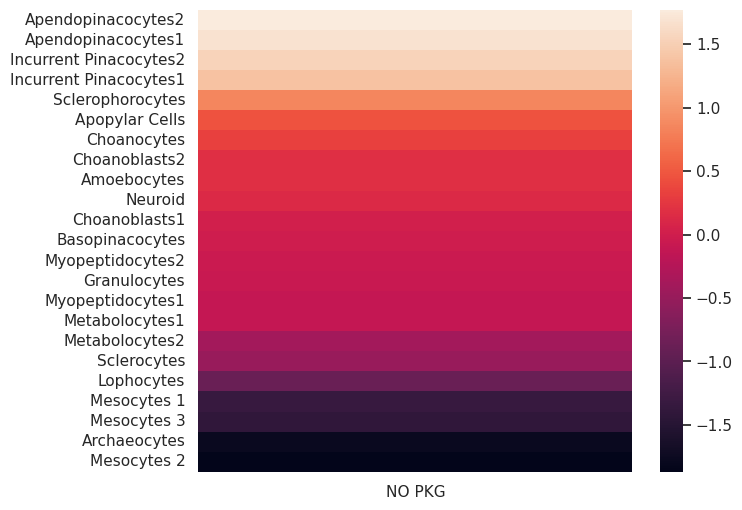

In [87]:
sns.heatmap(NO_PKG_zscores)

In [88]:
mech_PKG = pd.DataFrame(mech_exp_pred_merge[mech_exp_pred_merge['Kinase'].str.contains('PKG')]['Protein.ID'].drop_duplicates())
mech_PKG = mech_PKG.merge(merged_names, how='left')
mech_PKG['annotation'] = [gene[:110] for gene in mech_PKG['annotation']]

In [89]:
mech_PKG_matrix = grouped_obs_mean(adata[:, mech_PKG['annotation']], group_key='cell_type')
mech_PKG_zscores = pd.DataFrame(scipy.stats.zscore((mech_PKG_matrix.sum(axis=0))/len(mech_PKG_matrix)))
mech_PKG_zscores.sort_values(by=0, ascending=False, inplace=True)
mech_PKG_zscores.rename(columns={0:'mech PKG'}, inplace=True)

<AxesSubplot: >

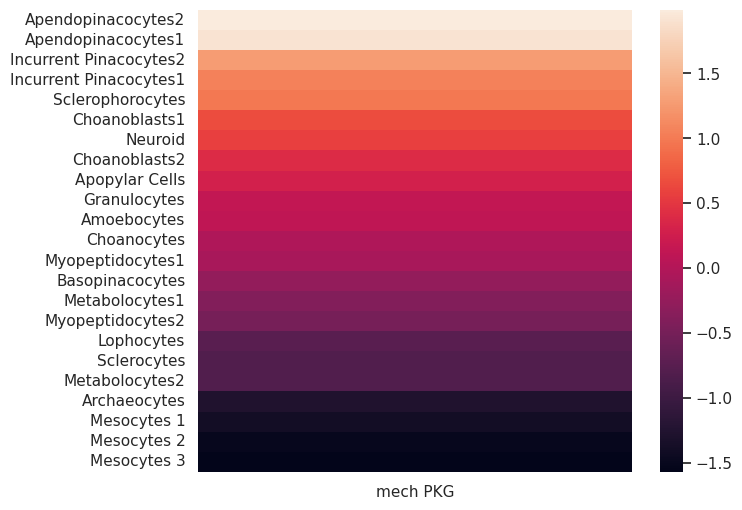

In [90]:
sns.heatmap(mech_PKG_zscores)

In both cases we see that the cell types of the pinacocyte family express proteins highest that are predicted to be phosphorylated due to NO- and mechanical treatment.

Now to do this a little more automated:

In [91]:
def kinase_target_matrix(experiment, kinase, rename_to):
    dataframe = pd.DataFrame(experiment[experiment['Kinase'].str.contains(kinase)]['Protein.ID'].drop_duplicates())
    dataframe = dataframe.merge(merged_names, how='left')
    dataframe['annotation'] = [gene[:110] for gene in dataframe['annotation']]
    
    dataframe_matrix = grouped_obs_mean(adata[:, dataframe['annotation']], group_key='cell_type')
    dataframe_zscores = pd.DataFrame(scipy.stats.zscore((dataframe_matrix.sum(axis=0))/len(dataframe_matrix)))
    dataframe_zscores.sort_values(by=0, ascending=False, inplace=True)
    dataframe_zscores.rename(columns={0:rename_to}, inplace=True)
    return(dataframe_zscores)

In [92]:
mech_Akt_zscores = kinase_target_matrix(mech_exp_pred_merge, 'Akt', 'mech Akt')
NO_Akt_zscores = kinase_target_matrix(no_exp_pred_merge, 'Akt', 'NO Akt')
mech_ERK_zscores = kinase_target_matrix(mech_exp_pred_merge, 'ERK', 'mech ERK')
NO_ERK_zscores = kinase_target_matrix(no_exp_pred_merge, 'ERK', 'NO ERK')
mech_PKA_zscores = kinase_target_matrix(mech_exp_pred_merge, 'PKA', 'mech PKA')
NO_PKA_zscores = kinase_target_matrix(no_exp_pred_merge, 'PKA', 'NO PKA')
mech_MAPK_zscores = kinase_target_matrix(mech_exp_pred_merge, 'MAPK', 'mech MAPK')
NO_MAPK_zscores = kinase_target_matrix(no_exp_pred_merge, 'MAPK', 'NO MAPK')
mech_CAMK_zscores = kinase_target_matrix(mech_exp_pred_merge, 'CAMK', 'mech CAMK')
NO_CAMK_zscores = kinase_target_matrix(no_exp_pred_merge, 'CAMK', 'NO CAMK')

<AxesSubplot: >

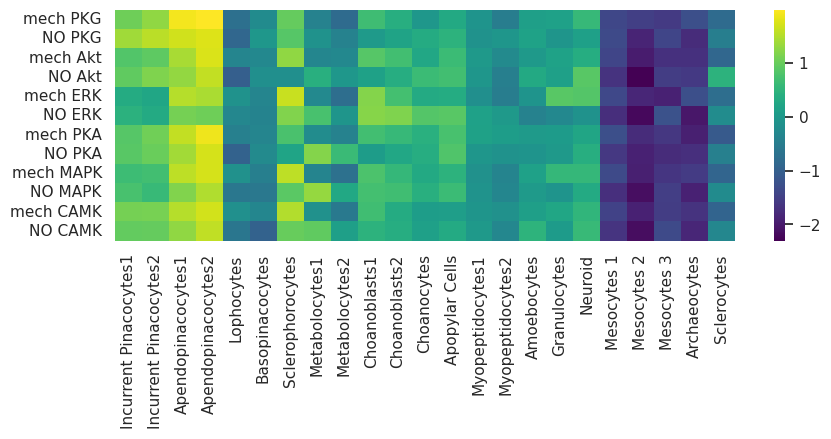

In [93]:
merge_heatmap = mech_PKG_zscores.merge(NO_PKG_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(mech_Akt_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(NO_Akt_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(mech_ERK_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(NO_ERK_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(mech_PKA_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(NO_PKA_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(mech_MAPK_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(NO_MAPK_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(mech_CAMK_zscores, left_index=True, right_index=True)
merge_heatmap = merge_heatmap.merge(NO_CAMK_zscores, left_index=True, right_index=True)

merge_heatmap = merge_heatmap.reindex(celltypes_by_family).T
columns_drop = ['Mesocytes 1', 'Mesocytes 2', 'Mesocytes 3']
#merge_heatmap = merge_heatmap.drop(columns_drop, axis=1)

fig, ax = plt.subplots(figsize=(10,3))
sns.heatmap(merge_heatmap, cmap='viridis')

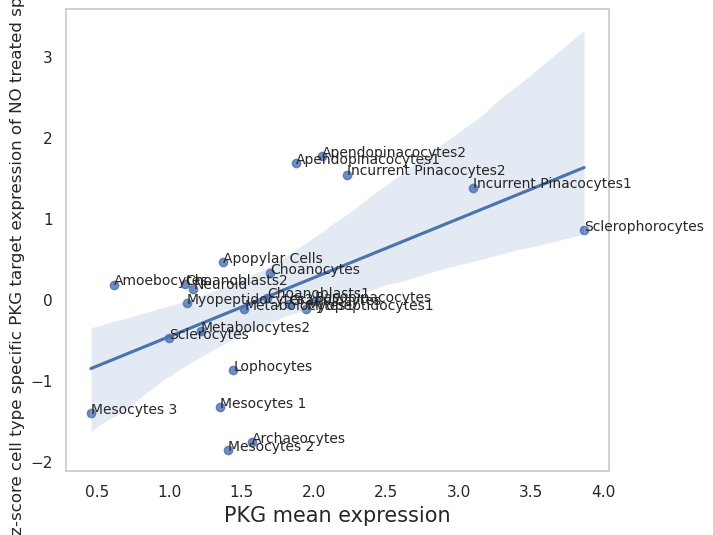

In [94]:
PKG_expression = grouped_obs_mean(adata[:, 'c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'], 'cell_type').T
PKG_expression_NO = PKG_expression.merge(NO_PKG_zscores, left_index=True, right_index=True)

ax = sns.regplot(data = PKG_expression_NO, x='c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II', y='NO PKG')
ax.set_ylabel('z-score cell type specific PKG target expression of NO treated sponges')
ax.set_xlabel('PKG mean expression', fontsize=15)
for i, point in PKG_expression_NO.iterrows():
    plt.text(point['c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'], point['NO PKG'], str(i), size=10)

In [95]:
PKG_expression_NO['c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'].corr(PKG_expression_NO['NO PKG'])

0.5268813421273507

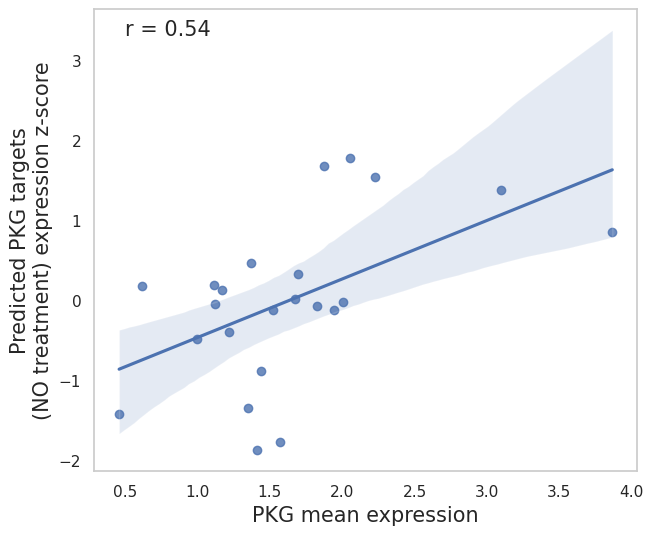

In [96]:
PKG_expression = grouped_obs_mean(adata[:, 'c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'], 'cell_type').T
PKG_expression_NO = PKG_expression.merge(NO_PKG_zscores, left_index=True, right_index=True)

ax = sns.regplot(data = PKG_expression_NO, x='c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II', y='NO PKG')
ax.set_ylabel('Predicted PKG targets\n(NO treatment) expression z-score', fontsize=15)
ax.set_xlabel('PKG mean expression', fontsize=15)
ax.text(0.5, 3.3, 'r = 0.54', fontsize=15)

plt.savefig('../paper/figures/fig3/PKG_NO_target_correlation.svg', bbox_inches='tight')

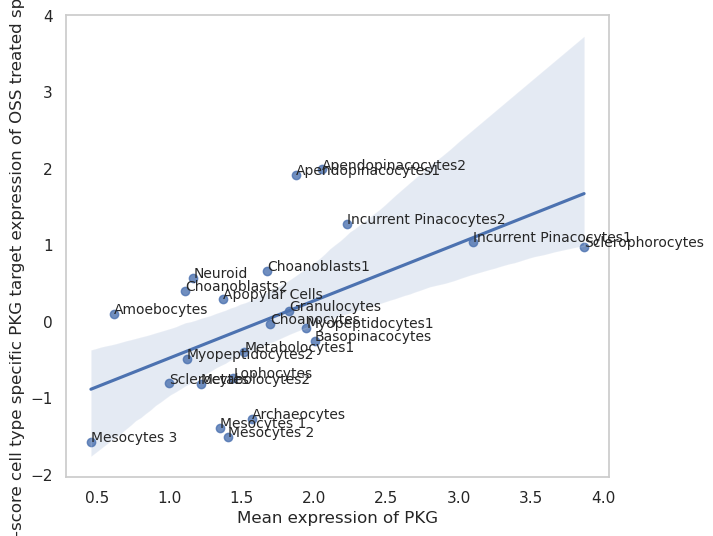

In [99]:
PKG_expression = grouped_obs_mean(adata[:, 'c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'], 'cell_type').T
PKG_expression_mech = PKG_expression.merge(mech_PKG_zscores, left_index=True, right_index=True)

ax = sns.regplot(data = PKG_expression_mech, x='c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II', y='mech PKG')
ax.set_ylabel('z-score cell type specific PKG target expression of OSS treated sponges')
ax.set_xlabel('Mean expression of PKG')
for i, point in PKG_expression_mech.iterrows():
    plt.text(point['c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'], point['mech PKG'], str(i), size=10)

In [100]:
PKG_expression_mech['c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II'].corr(PKG_expression_mech['mech PKG'])

0.5421301014207327

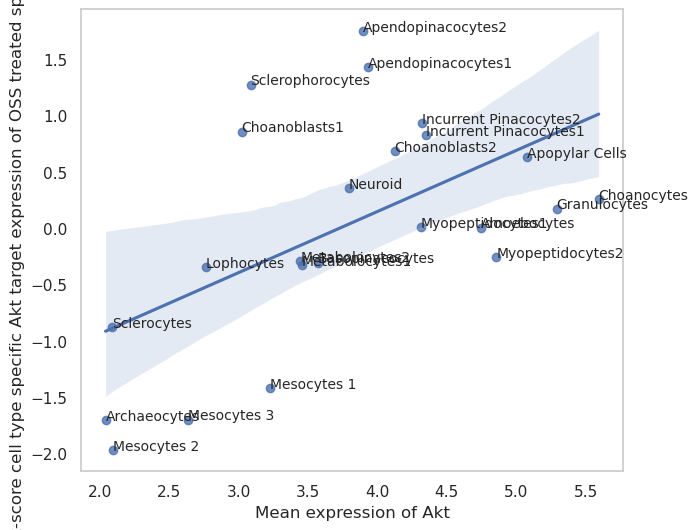

In [101]:
Akt_expression = grouped_obs_mean(adata[:, 'c101822-g1 AKT3 (v-akt murine thymoma viral oncogene homolog) - emapper OG'], 'cell_type').T
Akt_expression = Akt_expression.merge(mech_Akt_zscores, left_index=True, right_index=True)

ax = sns.regplot(data = Akt_expression, x='c101822-g1 AKT3 (v-akt murine thymoma viral oncogene homolog) - emapper OG', y='mech Akt')
ax.set_ylabel('z-score cell type specific Akt target expression of OSS treated sponges')
ax.set_xlabel('Mean expression of Akt')
for i, point in Akt_expression.iterrows():
    plt.text(point['c101822-g1 AKT3 (v-akt murine thymoma viral oncogene homolog) - emapper OG'], point['mech Akt'], str(i), size=10)

In [102]:
Akt_expression['c101822-g1 AKT3 (v-akt murine thymoma viral oncogene homolog) - emapper OG'].corr(Akt_expression['mech Akt'])

0.5423259686812139

### 3.2 Where are proteins expressed that are significantly regulated in phosphorylation (up-and down).

#### OSS Treatment

In [103]:
phospho_mech_sig['Protein.ID'] = phospho_mech_sig['Protein.ID'].str.strip()

/tmp/ipykernel_94/4254181792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phospho_mech_sig['Protein.ID'] = phospho_mech_sig['Protein.ID'].str.strip()


In [104]:
phospho_mech_sig = phospho_mech_sig.merge(merged_names, on='Protein.ID', how='left')

In [105]:
phospho_mech_sig_unique = phospho_mech_sig['annotation'].drop_duplicates()
phospho_mech_sig_unique = [gene[:110] for gene in phospho_mech_sig_unique]

In [106]:
dataframe_matrix = grouped_obs_mean(adata[:, phospho_mech_sig_unique], group_key='cell_type')
dataframe_zscores_mech_sig = pd.DataFrame(scipy.stats.zscore((dataframe_matrix.sum(axis=0))/len(dataframe_matrix)))
dataframe_zscores_mech_sig.sort_values(by=0, ascending=False, inplace=True)
dataframe_zscores_mech_sig.rename(columns={0:'Mechanical Significant'}, inplace=True)

<AxesSubplot: >

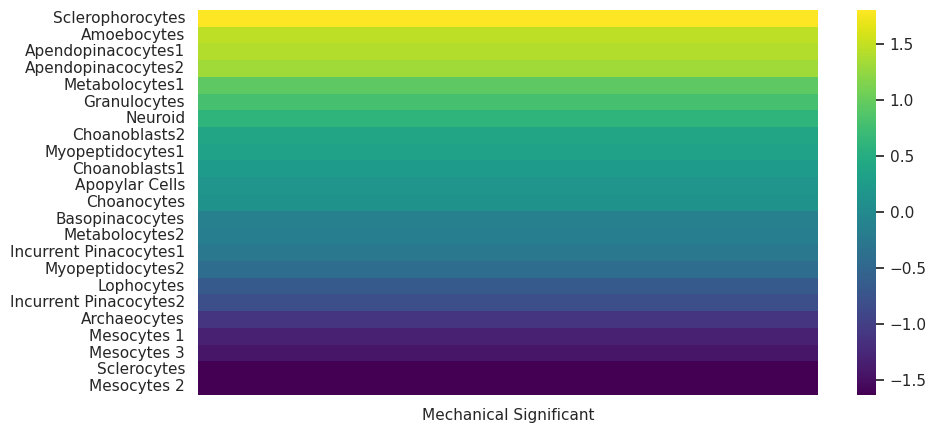

In [107]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(dataframe_zscores_mech_sig, cmap='viridis')

#### NO treatment

In [108]:
phospho_no_sig['Protein.ID'] = phospho_no_sig['Protein.ID'].str.strip()

/tmp/ipykernel_94/2294845412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phospho_no_sig['Protein.ID'] = phospho_no_sig['Protein.ID'].str.strip()


In [109]:
phospho_no_sig = phospho_no_sig.merge(merged_names, on='Protein.ID', how='left')

In [110]:
phospho_no_sig_unique = phospho_no_sig['annotation'].drop_duplicates()
phospho_no_sig_unique = [gene[:110] for gene in phospho_no_sig_unique]

In [111]:
dataframe_matrix = grouped_obs_mean(adata[:, phospho_no_sig_unique], group_key='cell_type')
dataframe_zscores_no_sig = pd.DataFrame(scipy.stats.zscore((dataframe_matrix.sum(axis=0))/len(dataframe_matrix)))
dataframe_zscores_no_sig.sort_values(by=0, ascending=False, inplace=True)
dataframe_zscores_no_sig.rename(columns={0:'Mechanical Significant'}, inplace=True)

<AxesSubplot: >

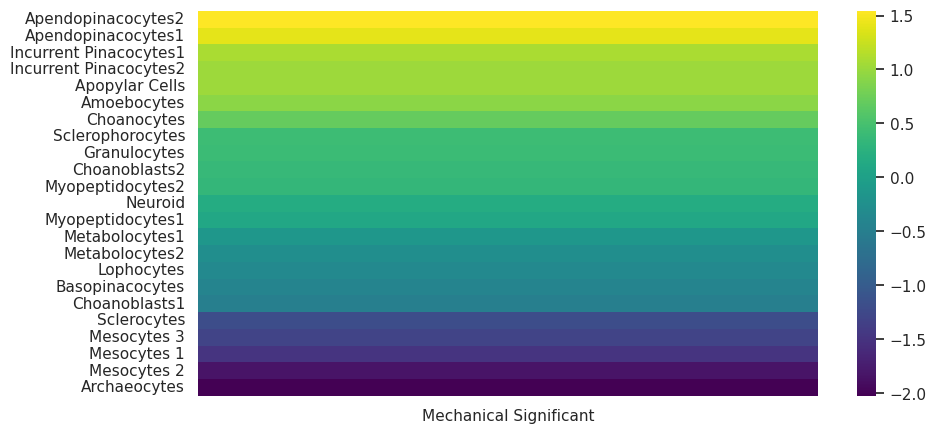

In [112]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(dataframe_zscores_no_sig, cmap='viridis')

This means that NO treatment leads specifically to a phosphorlation of proteins that are expressed in Apendopinacocytes and Incurrent Pinacocytes.

<AxesSubplot: >

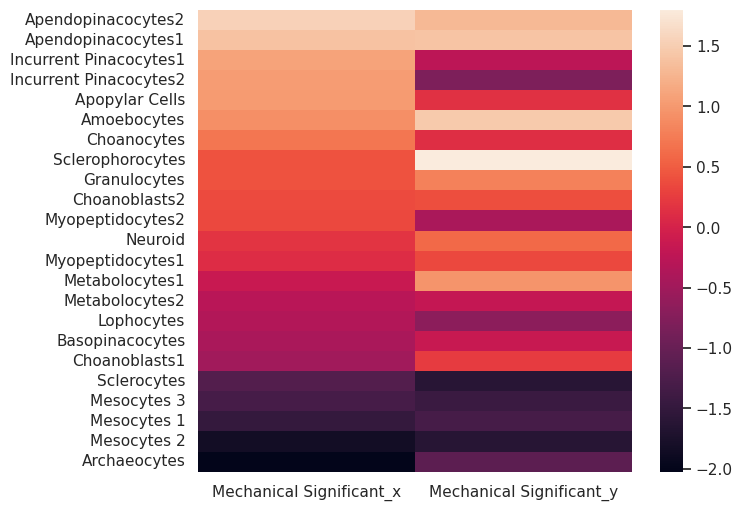

In [115]:
sns.heatmap(dataframe_zscores_no_sig.merge(dataframe_zscores_mech_sig, left_index=True, right_index=True))

# 4. Phosphorylation of proteins of interest

Some proteins are of special interest, especially if there is known phorphorylations happening in the pathways that we are interested in. Of course in this experiments we are never able to capture all phosphorylation events possible. ALso the quantity of phosphoryaltion is probably different for all proteins in terms of effects on their functions.

Import full dataset that includes the values of all triplicates:

In [21]:
phospho_full = pd.read_csv('../data/proteomics/phospho/Contractions_analysis_V1/data_analysis_results_V1/Full_dataset_V1.csv')
phospho_full['Protein.ID'] = phospho_full['Protein.ID'].str.strip()
phospho_full = phospho_full.merge(merged_names, how='left', on='Protein.ID')
phospho_full = phospho_full[~phospho_full['annotation'].isna()]

/tmp/ipykernel_178/903801151.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  phospho_full = pd.read_csv('../data/proteomics/phospho/Contractions_analysis_V1/data_analysis_results_V1/Full_dataset_V1.csv')


### 4.1 Volcanoplots of peptides of interest 

In [16]:
phospho_mech['pvalue_fdr_log10'] = -1 * np.log10(phospho_mech['pvalue.fdrtool'])
phospho_no['pvalue_fdr_log10'] = -1 * np.log10(phospho_no['pvalue.fdrtool'])

In [17]:
phospho_no['Protein.ID'] = phospho_no['Protein.ID'].str.strip()
phospho_no_annotated = phospho_no.merge(merged_names, on='Protein.ID', how='left')
phospho_no_annotated = phospho_no_annotated[~phospho_no_annotated['annotation'].isna()]

phospho_mech['Protein.ID'] = phospho_mech['Protein.ID'].str.strip()
phospho_mech_annotated = phospho_mech.merge(merged_names, on='Protein.ID', how='left')
phospho_mech_annotated = phospho_mech_annotated[~phospho_mech_annotated['annotation'].isna()]

In [122]:
def volcanoplot_mech(modified_peptide):
    fig, ax = plt.subplots()

    sns.scatterplot(data=phospho_mech, x='logFC', y='pvalue_fdr_log10', alpha=0.15)
    ax.set_ylabel('-log10 FDR p-value', fontsize = 15)
    ax.set_xlabel('log2 Fold change', fontsize = 15)
    ax.set_title('Agitated sponge - Phosphopeptides')

    sns.scatterplot(data=phospho_mech[phospho_mech['Modified.Peptide'] == modified_peptide], x='logFC', y='pvalue_fdr_log10', color='red')

In [123]:
def volcanoplot_no(modified_peptide):
    fig, ax = plt.subplots()

    sns.scatterplot(data=phospho_no, x='logFC', y='pvalue_fdr_log10', alpha=0.15)
    ax.set_ylabel('-log10 FDR p-value', fontsize = 15)
    ax.set_xlabel('log2 Fold change', fontsize = 15)
    ax.set_title('Agitated sponge - Phosphopeptides')

    sns.scatterplot(data=phospho_no[phospho_no['Modified.Peptide'] == modified_peptide], x='logFC', y='pvalue_fdr_log10', color='red')

Peptides of all proteins involved in acto-myosin contractility:

In [14]:
actin = ['c93514-g2 (ACTIN) - emapper OG']
actin_color = '#F69799'

myosin = ['c101822-g1 AKT3 (v-akt murine thymoma viral oncogene homolog) - emapper OG', 'c104726-g3 1-to-4 MYH9/10/11/14 myosin heavy chain 1', 
          'c102529-g1 GUCY1B2 (guanylate cyclase 1, soluble) - emapper OG', 'c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide synthase 3', 
          'c96307-g1 1-to-2 STK17B,STK17A serine/threonine kinase 17b', 'c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesterase 1C', 
          'c101375-g1 1-to-3 PDE1B,PDE1C,PDE1A phosphodiesterase 1B', 'c101919-g1 (guanylate cyclase 1, soluble) - emapper OG']
myosin_color = '#D41E47'

actin_dynamics = ['c100975-g1 (gelsolin) - emapper OG']
actin_dynamics_color = '#3C6FB6'

cross_linker = ['c99862-g1 LIMA1 (LIM domain and actin binding 1) - emapper OG', 'c103703-g1 (Filamin/ABP280 repeat) - emapper OG', 
                'c103902-g5 FLNB (Filamin A, alpha) - emapper OG']
cross_linker_color = '#006664'

attachment = ['c103424-g3 SVIL (supervillin) - blastp', 'c103122-g3 4-to-2 TLN1,TLN2 talin 1', 'c104780-g1 TLN1 (K06271 talin) - emapper OG', 'c101590-g2 PCDH15 (protocadherin-related 15) - emapper OG']
attachment_color = '#F39E1E'

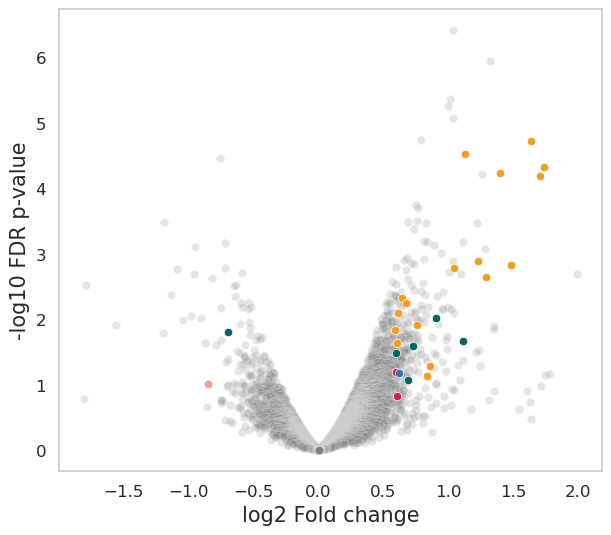

In [143]:
fig, ax = plt.subplots()

sns.scatterplot(data = phospho_mech_annotated, x='logFC', y='pvalue_fdr_log10', alpha=0.2, color='grey')

plt.xticks(fontsize=12)
ax.set_xlabel('log2 Fold change', fontsize=15)

plt.yticks(fontsize=12)
ax.set_ylabel('-log10 FDR p-value', fontsize=15)

sns.scatterplot(data = phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(actin)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=actin_color)
sns.scatterplot(data = phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(myosin)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=myosin_color)
sns.scatterplot(data = phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(actin_dynamics)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=actin_dynamics_color)
sns.scatterplot(data = phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(cross_linker)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=cross_linker_color)
sns.scatterplot(data = phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(attachment)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=attachment_color)

plt.savefig('../paper/figures/fig3/Phosphoe_mech_volcanoplot.svg', bbox_inches='tight')
plt.savefig('../paper/figures/fig3/Phosphoe_mech_volcanoplot.png', bbox_inches='tight', dpi=300)

Which are the proteins behind the dots?

In [144]:
phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(actin)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))]['annotation']

742    c93514-g2 (ACTIN) - emapper OG
Name: annotation, dtype: object

In [145]:
phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(myosin)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))]['annotation']

496     c101822-g1 AKT3 (v-akt murine thymoma viral on...
1178    c104726-g3 1-to-4 MYH9/10/11/14 myosin heavy c...
Name: annotation, dtype: object

In [146]:
phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(actin_dynamics)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))]['annotation']

504    c100975-g1 (gelsolin) - emapper OG
Name: annotation, dtype: object

In [147]:
phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(cross_linker)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))]['annotation']

112    c99862-g1 LIMA1 (LIM domain and actin binding ...
161      c103902-g5 FLNB (Filamin A, alpha) - emapper OG
204      c103703-g1 (Filamin/ABP280 repeat) - emapper OG
228    c99862-g1 LIMA1 (LIM domain and actin binding ...
273    c99862-g1 LIMA1 (LIM domain and actin binding ...
657    c99862-g1 LIMA1 (LIM domain and actin binding ...
Name: annotation, dtype: object

In [148]:
phospho_mech_annotated[(phospho_mech_annotated['annotation'].isin(attachment)) & ((phospho_mech_annotated['hit_annotation'] == 'candidate') | (phospho_mech_annotated['hit_annotation'] == 'hit'))]['annotation']

6      c101590-g2 PCDH15 (protocadherin-related 15) -...
7      c101590-g2 PCDH15 (protocadherin-related 15) -...
9      c101590-g2 PCDH15 (protocadherin-related 15) -...
10     c101590-g2 PCDH15 (protocadherin-related 15) -...
12     c101590-g2 PCDH15 (protocadherin-related 15) -...
32     c101590-g2 PCDH15 (protocadherin-related 15) -...
36     c101590-g2 PCDH15 (protocadherin-related 15) -...
39     c101590-g2 PCDH15 (protocadherin-related 15) -...
47     c101590-g2 PCDH15 (protocadherin-related 15) -...
70                c103424-g3 SVIL (supervillin) - blastp
80                c103424-g3 SVIL (supervillin) - blastp
101               c103424-g3 SVIL (supervillin) - blastp
141               c103424-g3 SVIL (supervillin) - blastp
154                  c103122-g3 4-to-2 TLN1,TLN2 talin 1
212               c103424-g3 SVIL (supervillin) - blastp
414    c101590-g2 PCDH15 (protocadherin-related 15) -...
576                  c103122-g3 4-to-2 TLN1,TLN2 talin 1
Name: annotation, dtype: object

Now for NO treatment:

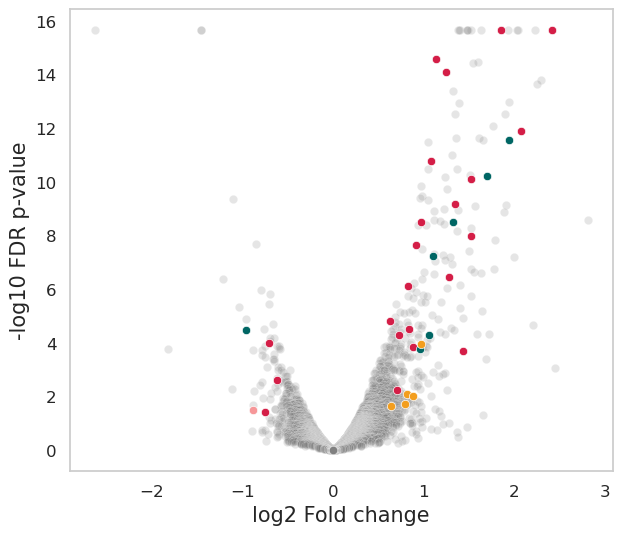

In [149]:
fig, ax = plt.subplots()

sns.scatterplot(data = phospho_no_annotated, x='logFC', y='pvalue_fdr_log10', alpha=0.2, color='grey')

plt.xticks(fontsize=12)
ax.set_xlabel('log2 Fold change', fontsize=15)

plt.yticks(fontsize=12)
ax.set_ylabel('-log10 FDR p-value', fontsize=15)

sns.scatterplot(data = phospho_no_annotated[(phospho_no_annotated['annotation'].isin(actin)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=actin_color)
sns.scatterplot(data = phospho_no_annotated[(phospho_no_annotated['annotation'].isin(myosin)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=myosin_color)
sns.scatterplot(data = phospho_no_annotated[(phospho_no_annotated['annotation'].isin(actin_dynamics)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=actin_dynamics_color)
sns.scatterplot(data = phospho_no_annotated[(phospho_no_annotated['annotation'].isin(cross_linker)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=cross_linker_color)
sns.scatterplot(data = phospho_no_annotated[(phospho_no_annotated['annotation'].isin(attachment)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))], x='logFC', y='pvalue_fdr_log10', color=attachment_color)

plt.savefig('../paper/figures/fig3/Phosphoe_no_volcanoplot.svg', bbox_inches='tight')
plt.savefig('../paper/figures/fig3/Phosphoe_no_volcanoplot.png', bbox_inches='tight', dpi=300)

In [150]:
phospho_no_annotated[(phospho_no_annotated['annotation'].isin(actin)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))]['annotation']

731    c93514-g2 (ACTIN) - emapper OG
Name: annotation, dtype: object

In [151]:
phospho_no_annotated[(phospho_no_annotated['annotation'].isin(myosin)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))]['annotation']

14     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
16     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
17     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
20     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
29     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
36     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
42     c101375-g1 1-to-3 PDE1B,PDE1C,PDE1A phosphodie...
49     c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide ...
59     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
66     c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide ...
69     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
86     c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide ...
91     c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
120    c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesteras...
133    c101919-g1 (guanylate cyclase 1, soluble) - em...
149    c101919-g1 (guanylate cyclase 1, soluble) - em...
163    c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide ...
176    c103457-g1 1-to-3 NOS3,N

In [152]:
phospho_no_annotated[(phospho_no_annotated['annotation'].isin(actin_dynamics)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))]['annotation']

Series([], Name: annotation, dtype: object)

In [153]:
phospho_no_annotated[(phospho_no_annotated['annotation'].isin(cross_linker)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))]['annotation']

32     c99862-g1 LIMA1 (LIM domain and actin binding ...
40     c99862-g1 LIMA1 (LIM domain and actin binding ...
60     c99862-g1 LIMA1 (LIM domain and actin binding ...
74     c99862-g1 LIMA1 (LIM domain and actin binding ...
136      c103902-g5 FLNB (Filamin A, alpha) - emapper OG
150      c103703-g1 (Filamin/ABP280 repeat) - emapper OG
190      c103703-g1 (Filamin/ABP280 repeat) - emapper OG
Name: annotation, dtype: object

In [154]:
phospho_no_annotated[(phospho_no_annotated['annotation'].isin(attachment)) & ((phospho_no_annotated['hit_annotation'] == 'candidate') | (phospho_no_annotated['hit_annotation'] == 'hit'))]['annotation']

166          c104780-g1 TLN1 (K06271 talin) - emapper OG
420    c101590-g2 PCDH15 (protocadherin-related 15) -...
451    c101590-g2 PCDH15 (protocadherin-related 15) -...
592    c101590-g2 PCDH15 (protocadherin-related 15) -...
627    c101590-g2 PCDH15 (protocadherin-related 15) -...
Name: annotation, dtype: object

How do phosphorylations of NO treatment and agitation correlate?

In [15]:
phospho_merge_annotated = phospho_no_annotated.merge(phospho_mech_annotated, how='inner', on='Modified.Peptide', suffixes=('_no', '_mech'))

NameError: name 'phospho_no_annotated' is not defined

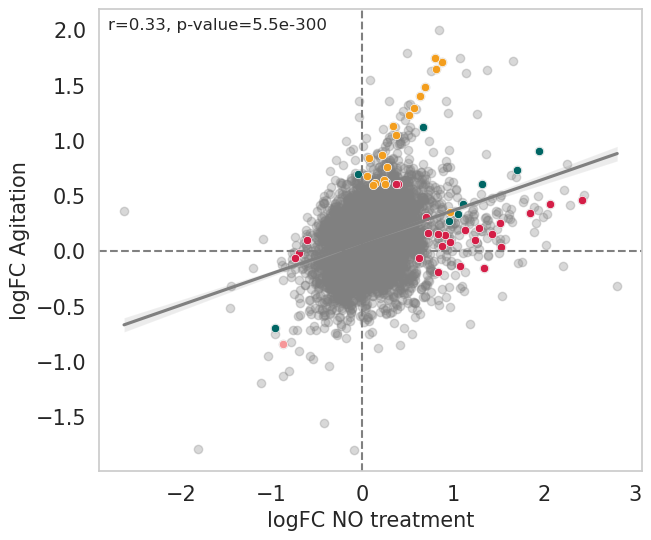

In [165]:
fig, ax = plt.subplots()

sns.regplot(data = phospho_merge_annotated, x='logFC_no', y='logFC_mech', fit_reg = True, scatter_kws={'alpha':0.3}, color='grey')
ax.set_ylabel('logFC Agitation', fontsize=15)
ax.set_xlabel('logFC NO treatment', fontsize=15)

ax.axhline(y=0, linestyle='--', color='gray')
ax.axvline(x=0, linestyle='--', color='gray')

sns.scatterplot(data = phospho_merge_annotated[(phospho_merge_annotated['annotation_mech'].isin(actin)) & (((phospho_merge_annotated['hit_annotation_no'] == 'candidate') | (phospho_merge_annotated['hit_annotation_no'] == 'hit')) | ((phospho_merge_annotated['hit_annotation_mech'] == 'candidate') | (phospho_merge_annotated['hit_annotation_mech'] == 'hit')))], x='logFC_no', y='logFC_mech', color=actin_color)
sns.scatterplot(data = phospho_merge_annotated[(phospho_merge_annotated['annotation_mech'].isin(myosin)) & (((phospho_merge_annotated['hit_annotation_no'] == 'candidate') | (phospho_merge_annotated['hit_annotation_no'] == 'hit')) | ((phospho_merge_annotated['hit_annotation_mech'] == 'candidate') | (phospho_merge_annotated['hit_annotation_mech'] == 'hit')))], x='logFC_no', y='logFC_mech', color=myosin_color)
sns.scatterplot(data = phospho_merge_annotated[(phospho_merge_annotated['annotation_mech'].isin(actin_dynamics)) & (((phospho_merge_annotated['hit_annotation_no'] == 'candidate') | (phospho_merge_annotated['hit_annotation_no'] == 'hit')) | ((phospho_merge_annotated['hit_annotation_mech'] == 'candidate') | (phospho_merge_annotated['hit_annotation_mech'] == 'hit')))], x='logFC_no', y='logFC_mech', color=actin_dynamics_color)
sns.scatterplot(data = phospho_merge_annotated[(phospho_merge_annotated['annotation_mech'].isin(cross_linker)) & (((phospho_merge_annotated['hit_annotation_no'] == 'candidate') | (phospho_merge_annotated['hit_annotation_no'] == 'hit')) | ((phospho_merge_annotated['hit_annotation_mech'] == 'candidate') | (phospho_merge_annotated['hit_annotation_mech'] == 'hit')))], x='logFC_no', y='logFC_mech', color=cross_linker_color)
sns.scatterplot(data = phospho_merge_annotated[(phospho_merge_annotated['annotation_mech'].isin(attachment)) & (((phospho_merge_annotated['hit_annotation_no'] == 'candidate') | (phospho_merge_annotated['hit_annotation_no'] == 'hit')) | ((phospho_merge_annotated['hit_annotation_mech'] == 'candidate') | (phospho_merge_annotated['hit_annotation_mech'] == 'hit')))], x='logFC_no', y='logFC_mech', color=attachment_color)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.text(-2.8, 2, 'r=0.33, p-value=5.5e-300')

plt.savefig('../paper/figures/fig3/Phospho_no_mech_correlation.png', bbox_inches='tight', dpi=300)

In [162]:
scipy.stats.pearsonr(phospho_merge_annotated['logFC_no'], phospho_merge_annotated['logFC_mech'])

PearsonRResult(statistic=0.3267413746085813, pvalue=5.582389441704015e-300)

### 4.2 Boxplots of proteins of interest

In [26]:
def plot_phosphopeptide(gene, gene_name, peptide, position, max_ylim_factor):
    info = phospho_full[(phospho_full['Protein.ID'].str.contains(gene)) & (phospho_full['Modified.Peptide'] == peptide)][['Protein.ID', 'Modified.Peptide', 'annotation',
       'norm_batchcl_raw_channel_contraction_mechanical_rep1',
       'norm_batchcl_raw_channel_contraction_mechanical_rep2',
       'norm_batchcl_raw_channel_contraction_mechanical_rep3',
       'norm_batchcl_raw_channel_contraction_no_rep1',
       'norm_batchcl_raw_channel_contraction_no_rep2',
       'norm_batchcl_raw_channel_contraction_no_rep3',
       'norm_batchcl_raw_channel_control_rep1',
       'norm_batchcl_raw_channel_control_rep2',
       'norm_batchcl_raw_channel_control_rep3']]
    
    data = {
    'Protein.ID': [gene] * 9,
    'Modified.Peptide': [peptide] * 9,
    'annotation': info['annotation'].iloc[0] * 9,
    'treatment': ['mechanical', 'mechanical', 'mechanical', 'contraction_no', 'contraction_no', 'contraction_no', 'control', 'control', 'control'],
    'rep': ['rep1', 'rep2', 'rep3'] * 3,
    'Value': [info['norm_batchcl_raw_channel_contraction_mechanical_rep1'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_mechanical_rep2'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_mechanical_rep3'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_no_rep1'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_no_rep2'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_no_rep3'].iloc[0],
              info['norm_batchcl_raw_channel_control_rep1'].iloc[0],
              info['norm_batchcl_raw_channel_control_rep2'].iloc[0],
              info['norm_batchcl_raw_channel_control_rep3'].iloc[0]]
    }
    data['Value_log10'] = np.log2(data['Value'])
    df = pd.DataFrame(data)
    
    labels=['Agitation', 'NO treatment', 'Control']
    
    max_ylim = df["Value_log10"].max()    

    fig, ax = plt.subplots(figsize=(4, 3))
    ax = sns.boxplot(data=df, x='treatment', y='Value_log10', color='white')

    ax.set_xlabel(position, fontsize=15)
    ax.set_ylabel(f'Log2 normalized, batch corrected\npeptide signal intensity', fontsize=13)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    new_ylim = (ax.get_ylim()[0], max_ylim * max_ylim_factor)
    ax.set_ylim(new_ylim)
    plt.title(f'{gene_name}\n{peptide}', fontsize=15)
    
    gene_name = gene_name.replace('/', '-')
    
    plt.savefig(f'../paper/phosphopep_boxplots/{gene_name}_{gene}_{peptide}.svg', bbox_inches='tight')

/tmp/ipykernel_1325/3014617506.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


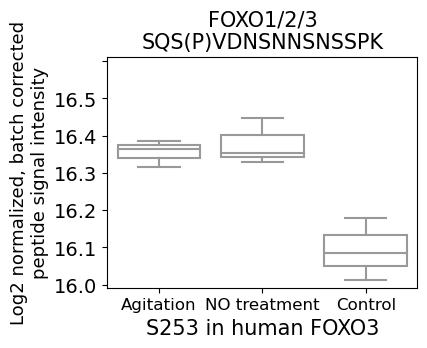

In [19]:
plot_phosphopeptide('m.49045', 'FOXO1/2/3', 'SQS(P)VDNSNNSNSSPK', 'S253 in human FOXO3', 1.01)

In [187]:
phospho_merge_annotated[(phospho_merge_annotated['Protein.ID_mech'].str.contains('m.49045')) & (phospho_merge_annotated['Modified.Peptide'] == 'SQS(P)VDNSNNSNSSPK')][['annotation_mech', 'pvalue_no', 'pvalue_mech']]

annotation_mech  pvalue_no  pvalue_mech
1079  c101327-g2 FOXO3 (forkhead box) - emapper OG   0.026371     0.036323

/tmp/ipykernel_94/3014617506.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


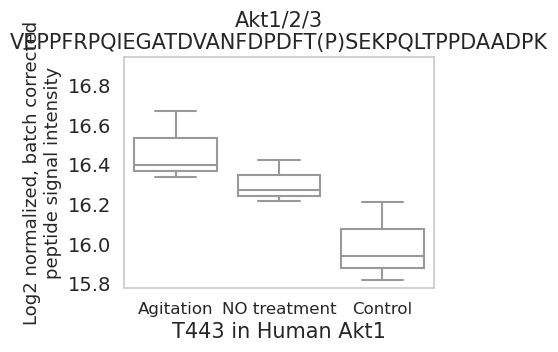

In [173]:
plot_phosphopeptide('m.52038', 'Akt1/2/3', 'VEPPFRPQIEGATDVANFDPDFT(P)SEKPQLTPPDAADPK', 'T443 in Human Akt1', 1.02)

In [188]:
phospho_merge_annotated[(phospho_merge_annotated['Protein.ID_mech'].str.contains('m.52038')) & (phospho_merge_annotated['Modified.Peptide'] == 'VEPPFRPQIEGATDVANFDPDFT(P)SEKPQLTPPDAADPK')][['annotation_mech', 'pvalue_no', 'pvalue_mech']]

annotation_mech  pvalue_no  \
1715  c101822-g1 AKT3 (v-akt murine thymoma viral on...   0.055317   

      pvalue_mech  
1715     0.008713

Many of the reported phosphorylation sites in human endothelial NOS (eNOS, NOS3) are simply non-existant in the sponge ortholog. On the other hand we see some sites differentially phosphorylated in the sponge NOS (such as the two posted above) that change in mech and NO treated sponges however do not have a counterpart in the human NOS, either because there is no Ser or Thr on that position or the the whole peptide is on a stretch that is completely missing in the human NOS. 

/tmp/ipykernel_94/3014617506.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


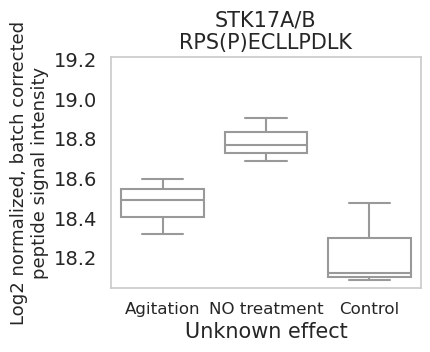

In [174]:
plot_phosphopeptide('m.27189', 'STK17A/B', 'RPS(P)ECLLPDLK', 'Unknown effect', 1.02)

## Boxplots for all proteins involved in acto-myosin contractility, dynamics, attachment, etc.

These boxplots show all significant as well as non significantly changing phosphopeptides measured for the protein groups defined above. I will save those and make them public in a repository, however, I will not show them as a supplement figure.

In [34]:
def plot_phosphopeptide_png(gene, gene_name, peptide, position, max_ylim_factor):
    info = phospho_full[(phospho_full['Protein.ID'].str.contains(gene)) & (phospho_full['Modified.Peptide'] == peptide)][['Protein.ID', 'Modified.Peptide', 'annotation',
       'norm_batchcl_raw_channel_contraction_mechanical_rep1',
       'norm_batchcl_raw_channel_contraction_mechanical_rep2',
       'norm_batchcl_raw_channel_contraction_mechanical_rep3',
       'norm_batchcl_raw_channel_contraction_no_rep1',
       'norm_batchcl_raw_channel_contraction_no_rep2',
       'norm_batchcl_raw_channel_contraction_no_rep3',
       'norm_batchcl_raw_channel_control_rep1',
       'norm_batchcl_raw_channel_control_rep2',
       'norm_batchcl_raw_channel_control_rep3']]
    
    data = {
    'Protein.ID': [gene] * 9,
    'Modified.Peptide': [peptide] * 9,
    'annotation': info['annotation'].iloc[0] * 9,
    'treatment': ['mechanical', 'mechanical', 'mechanical', 'contraction_no', 'contraction_no', 'contraction_no', 'control', 'control', 'control'],
    'rep': ['rep1', 'rep2', 'rep3'] * 3,
    'Value': [info['norm_batchcl_raw_channel_contraction_mechanical_rep1'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_mechanical_rep2'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_mechanical_rep3'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_no_rep1'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_no_rep2'].iloc[0],
              info['norm_batchcl_raw_channel_contraction_no_rep3'].iloc[0],
              info['norm_batchcl_raw_channel_control_rep1'].iloc[0],
              info['norm_batchcl_raw_channel_control_rep2'].iloc[0],
              info['norm_batchcl_raw_channel_control_rep3'].iloc[0]]
    }
    data['Value_log10'] = np.log2(data['Value'])
    df = pd.DataFrame(data)
    
    labels=['Agitation', 'NO treatment', 'Control']
    
    max_ylim = df["Value_log10"].max()    

    fig, ax = plt.subplots(figsize=(4, 3))
    ax = sns.boxplot(data=df, x='treatment', y='Value_log10', color='white')

    ax.set_xlabel(position, fontsize=15)
    ax.set_ylabel(f'Log2 normalized, batch corrected\npeptide signal intensity', fontsize=13)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    new_ylim = (ax.get_ylim()[0], max_ylim * max_ylim_factor)
    ax.set_ylim(new_ylim)
    plt.title(f'{gene_name}\n{peptide}', fontsize=15)
    
    gene_name = gene_name.replace('/', '-')
    
    plt.savefig(f'../paper/phosphopep_boxplots/{gene_name}_{gene}_{peptide}.png', bbox_inches='tight')

In [35]:
%%capture --no-display

for protein in actin:
    df = phospho_full[phospho_full['annotation'] == protein]
    df = df[df['Modified.Peptide'].str.contains('\(')]
    for i, row in df.iterrows():
        protein_id = row['Protein.ID']
        peptides = row['Modified.Peptide']
        annotation = row['annotation']
        plt.ioff()
        plot_phosphopeptide_png(protein_id, annotation, peptides, 'putative unknown effect', 1.02)

In [36]:
%%capture --no-display

for protein in actin_dynamics:
    df = phospho_full[phospho_full['annotation'] == protein]
    df = df[df['Modified.Peptide'].str.contains('\(')]
    for i, row in df.iterrows():
        protein_id = row['Protein.ID']
        peptides = row['Modified.Peptide']
        annotation = row['annotation']
        plot_phosphopeptide_png(protein_id, annotation, peptides, 'putative unknown effect', 1.02)

In [37]:
%%capture --no-display

for protein in myosin:
    df = phospho_full[phospho_full['annotation'] == protein]
    df = df[df['Modified.Peptide'].str.contains('\(')]
    for i, row in df.iterrows():
        protein_id = row['Protein.ID']
        peptides = row['Modified.Peptide']
        annotation = row['annotation']
        plot_phosphopeptide_png(protein_id, annotation, peptides, 'putative unknown effect', 1.02)

In [38]:
%%capture --no-display

for protein in cross_linker:
    df = phospho_full[phospho_full['annotation'] == protein]
    df = df[df['Modified.Peptide'].str.contains('\(')]
    for i, row in df.iterrows():
        protein_id = row['Protein.ID']
        peptides = row['Modified.Peptide']
        annotation = row['annotation']
        plot_phosphopeptide_png(protein_id, annotation, peptides, 'putative unknown effect', 1.02)

In [39]:
%%capture --no-display

for protein in attachment:
    df = phospho_full[phospho_full['annotation'] == protein]
    df = df[df['Modified.Peptide'].str.contains('\(')]
    for i, row in df.iterrows():
        protein_id = row['Protein.ID']
        peptides = row['Modified.Peptide']
        annotation = row['annotation']
        plot_phosphopeptide_png(protein_id, annotation, peptides, 'putative unknown effect', 1.02)